In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# === Cell 1: imports & config ===
import os, math, gc
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.sparse import csr_matrix, dia_matrix
from tqdm import tqdm

DATA_DIR = "/content/drive/MyDrive/retailrocket"  # <-- change to your path
K_ITEMS = 5000                      # start small for speed; bump later (e.g., 10k, 20k)
SESSION_GAP_SEC = 30*60             # 30-min inactivity split
MAX_DWELL_SEC = 10*60               # cap per-step dwell at 10 min
TIME_BUCKET = "1D"                  # daily buckets for p_t and V(t)

pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 20)


In [8]:
# === Cell 2: loaders ===
def load_events():
    usecols = ["timestamp", "visitorid", "event", "itemid", "transactionid"]
    dtypes  = {"timestamp": np.int64, "visitorid": np.int64, "event": "category", "itemid": np.int64, "transactionid": "float64"}
    df = pd.read_csv(os.path.join(DATA_DIR, "events.csv"), usecols=usecols, dtype=dtypes)
    df = df.sort_values(["visitorid", "timestamp"], kind="mergesort").reset_index(drop=True)
    return df

def load_item_properties():
    cols = ["timestamp", "itemid", "property", "value"]
    p1 = pd.read_csv(os.path.join(DATA_DIR, "item_properties_part1.csv"), usecols=cols)
    p2 = pd.read_csv(os.path.join(DATA_DIR, "item_properties_part2.csv"), usecols=cols)
    props = pd.concat([p1, p2], axis=0, ignore_index=True)
    props = props.sort_values(["itemid", "timestamp"]).reset_index(drop=True)
    return props


In [9]:
# === Cell 3: utilities ===
def infer_ts_unit(ts_series: pd.Series) -> str:
    """
    Heuristic: if max timestamp > 1e11, treat as milliseconds; else seconds.
    Retailrocket is in milliseconds.
    """
    mx = int(ts_series.max())
    return "ms" if mx > 1e11 else "s"

def filter_events(df, keep_events=("view","addtocart"), min_ts=None, max_ts=None):
    if min_ts is not None: df = df[df["timestamp"] >= min_ts]
    if max_ts is not None: df = df[df["timestamp"] <  max_ts]
    if keep_events is not None:
        df = df[df["event"].isin(keep_events)]
    return df.reset_index(drop=True)

def add_sessions_fast(df, gap_sec=30*60):
    """
    Vectorized sessionization without groupby.apply (avoids deprecation warning and is faster).
    Assumes df sorted by visitorid, timestamp.
    """
    df = df.copy()
    # mark start of a visitor block
    new_visitor = (df["visitorid"].shift(1) != df["visitorid"])
    # time diff within same visitor
    dt = df["timestamp"].diff().where(~new_visitor, np.inf)
    session_break = (dt.values > gap_sec)
    # cumulative session ids within a visitor; reset when visitor changes
    # build a visitor-wise cumulative sum, then combine with visitor id to make global sessions
    session_incr = session_break.astype(np.int64)
    # cumulative sum but reset per visitor
    csum = df.groupby("visitorid", sort=False).cumcount()  # 0.. within each visitor
    # We can't directly cumsum session_incr per visitor easily; do it with groupby.transform on an array:
    session_local = df.groupby("visitorid", sort=False)["timestamp"].transform(
        lambda s: np.cumsum((s.diff().fillna(gap_sec+1).values > gap_sec).astype(np.int64))
    ).astype(np.int64)
    df["session"] = session_local
    # global session id
    df["session_global"] = (df["visitorid"].astype(str) + "_" + df["session"].astype(str)).astype("category").cat.codes
    return df


In [10]:
# === Cell 4: top-K items ===
def restrict_topk_items(df, K=5000):
    top_items = df["itemid"].value_counts().head(K).index
    df = df[df["itemid"].isin(top_items)].copy()
    item_index = pd.Index(sorted(df["itemid"].unique()))
    item_to_idx = pd.Series(np.arange(len(item_index), dtype=np.int64), index=item_index)
    df["iid"] = item_to_idx.loc[df["itemid"]].values
    return df, item_index, item_to_idx


In [11]:
# === Cell 5: transitions & exposures (REPLACE THIS WHOLE FUNCTION) ===
from scipy.sparse import csr_matrix, dia_matrix

def build_transitions(df, max_dwell_sec=10*60, self_loops=True):
    """
    Build (C, P, T) from a sessionized, iid-indexed events DataFrame.
    - Unit-aware dwell time (ms vs s)
    - Row-stochastic P
    - Optionally add lazy self-loops for rows with no outgoing transitions
    """
    # keep sort
    df = df.sort_values(["session_global", "timestamp"])
    df["iid_next"] = df.groupby("session_global")["iid"].shift(-1)
    df["ts_next"]  = df.groupby("session_global")["timestamp"].shift(-1)
    valid = df["iid_next"].notna()

    # transition counts C
    trans = df.loc[valid, ["iid", "iid_next"]].astype({"iid": np.int64, "iid_next": np.int64})
    N = trans.value_counts().rename("cnt").reset_index()
    N.columns = ["i", "j", "cnt"]
    n_items = int(df["iid"].max()) + 1
    C = csr_matrix((N["cnt"].values, (N["i"].values, N["j"].values)),
                   shape=(n_items, n_items), dtype=np.float64)

    # ---- UNIT-AWARE DWELL (ms vs s) ----
    # infer from your raw timestamps (they are in the same units as ts_next)
    unit = infer_ts_unit(df["timestamp"])           # 'ms' or 's'
    scale = 1e-3 if unit == "ms" else 1.0           # convert to seconds

    # exposure T_i (cap each step)
    dwell = df.loc[valid, ["iid", "timestamp", "ts_next"]].copy()
    dwell["dt"] = ((dwell["ts_next"] - dwell["timestamp"]) * scale)\
                    .clip(lower=1.0, upper=max_dwell_sec)
    Ti = dwell.groupby("iid")["dt"].sum().astype(np.float64)

    T = np.zeros(n_items, dtype=np.float64)
    T[Ti.index.values] = Ti.values
    T[T <= 0] = 1.0

    # ---- ROW-STOCHASTIC P ----
    rowsum = np.asarray(C.sum(axis=1)).ravel()
    row_inv = np.reciprocal(np.maximum(rowsum, 1.0))
    P = dia_matrix((row_inv, 0), shape=(n_items, n_items)).dot(C).tocsr()

    # add lazy self-loops where a row had no outgoing transitions
    if self_loops:
        zero = (rowsum == 0)
        if zero.any():
            P = P.tolil()
            P[zero, zero] = 1.0
            P = P.tocsr()

    return P, C, T

In [12]:
# === Cell 6: stationary pi, Q, reversible Q ===
def stationary_from_P(P, tol=1e-12, maxit=2000):
    """
    Power method for the left stationary distribution: pi^T P = pi^T.
    Uses sparse-friendly matvec: pi_new = (P^T @ pi).
    """
    n = P.shape[0]
    pi = np.ones(n, dtype=np.float64) / n
    for _ in range(maxit):
        # sparse-safe: P.T @ pi returns ndarray
        pi_new = (P.T @ pi)
        pi_new = np.asarray(pi_new, dtype=np.float64).ravel()
        s = pi_new.sum()
        if s <= 0 or not np.isfinite(s):
            # fallback normalization to avoid NaNs/infs
            pi_new = np.ones(n, dtype=np.float64) / n
        else:
            pi_new = pi_new / s
        if np.linalg.norm(pi_new - pi, 1) < tol:
            return pi_new
        pi = pi_new
    return pi  # return the last iterate if not converged

def estimate_Q_from_counts_and_exposure(C, T):
    C = C.tocsr()
    n = C.shape[0]
    rows, cols = C.nonzero()
    data = C.data / T[rows]
    Q_off = csr_matrix((data, (rows, cols)), shape=(n, n))
    out = np.asarray(Q_off.sum(axis=1)).ravel()
    Q = Q_off - dia_matrix((out, 0), shape=(n, n))
    return Q.tocsr()

def make_reversible_Q(Q, pi):
    n = Q.shape[0]
    Pi     = dia_matrix((pi, 0), shape=(n, n))
    Pi_inv = dia_matrix((1.0/np.maximum(pi, 1e-12), 0), shape=(n, n))
    Q_rev = 0.5 * (Q + Pi_inv.dot(Q.T).dot(Pi))
    out = np.asarray(Q_rev.sum(axis=1)).ravel()
    Q_rev = Q_rev - dia_matrix((out, 0), shape=Q_rev.shape)
    return Q_rev.tocsr()

def detailed_balance_gap(Q, pi, sample=20000):
    Q = Q.tocsr()
    r, c = Q.nonzero()
    mask = (r != c)
    r, c = r[mask], c[mask]
    if len(r) == 0:
        return 0.0
    if len(r) > sample:
        idx = np.random.choice(len(r), size=sample, replace=False)
        r, c = r[idx], c[idx]
    vals_ij = np.asarray(Q[r, c]).ravel()  # robust: no .A
    vals_ji = np.asarray(Q[c, r]).ravel()
    return float(np.mean(np.abs(pi[r]*vals_ij - pi[c]*vals_ji)))


In [13]:
# === Cell 7: time buckets & V(t) with ms fix ===
def compute_time_buckets(df, bucket="1D"):
    # Detect unit
    unit = infer_ts_unit(df["timestamp"])
    # Build counts per time bucket × item
    tmp = df[["timestamp", "iid"]].copy()
    tmp["dt"] = pd.to_datetime(tmp["timestamp"], unit=unit, utc=True).dt.tz_convert(None)
    tmp.set_index("dt", inplace=True)
    counts = tmp.groupby([pd.Grouper(freq=bucket), "iid"]).size().rename("cnt")
    frame = counts.reset_index().pivot_table(index="dt", columns="iid", values="cnt", fill_value=0)
    # Row-normalize to get p_t (probability over items in each time bucket)
    row_sum = frame.sum(axis=1).replace(0, np.nan)
    P_rows = frame.div(row_sum, axis=0).fillna(0.0)
    return P_rows

def rolling_popularity_V(P_rows, window=7):
    eps = 1e-12
    roll = P_rows.rolling(window=window, min_periods=1).mean()
    V = -np.log(eps + roll)
    return V


In [ ]:
# 1) Load & filter
events = load_events()
print(f"Events loaded: {len(events):,}")
events = filter_events(events, keep_events=("view","addtocart"))

Events loaded: 2,756,101


In [ ]:
events = events.sort_values(["visitorid", "timestamp"]).reset_index(drop=True)
events = add_sessions_fast(events, gap_sec=SESSION_GAP_SEC)

In [ ]:
events, item_index, item_to_idx = restrict_topk_items(events, K=K_ITEMS)
print(f"Unique items kept: {len(item_index):,}")

Unique items kept: 5,000


In [ ]:
P, C, T = build_transitions(events, max_dwell_sec=MAX_DWELL_SEC)
print(f"P shape={P.shape}, nnz={P.nnz:,}")
print(f"C shape={C.shape}, nnz={C.nnz:,}")


P shape=(5000, 5000), nnz=5,822
C shape=(5000, 5000), nnz=3,195


In [ ]:
# === Sanity Cell A1: checks immediately after build_transitions ===
import numpy as np
from scipy.sparse import isspmatrix

def check_after_build(P, C, T):
    assert isspmatrix(P) and isspmatrix(C), "P and C must be SciPy sparse matrices"
    # nonnegativity
    assert (P.data >= -1e-12).all(), "P has negative entries"
    # row-stochasticity
    row = np.asarray(P.sum(axis=1)).ravel()
    max_dev = float(np.abs(row - 1.0).max())
    print(f"[P] row-sum max deviation: {max_dev:.3e}")
    assert max_dev < 1e-9, "P rows are not stochastic (did you use the self-loop version?)"
    # self-loop rows actually inserted (rows with zero C-out but diag(P)=1)
    rowsum_C = np.asarray(C.sum(axis=1)).ravel()
    zero_out = (rowsum_C == 0)
    diagP = P.diagonal()
    used_self = int(np.sum(zero_out & (diagP > 0.99)))
    print(f"[P] self-loop rows inserted: {used_self}")
    # exposure positive
    assert np.all(T > 0), "Exposure T has non-positive entries"

check_after_build(P, C, T)

[P] row-sum max deviation: 2.220e-16
[P] self-loop rows inserted: 2627


In [ ]:
pi = stationary_from_P(P)
Q  = estimate_Q_from_counts_and_exposure(C, T)
Q_rev = make_reversible_Q(Q, pi)
print(f"Q_rev shape={Q_rev.shape}, nnz={Q_rev.nnz:,}")
print("Detailed-balance gap (Q):", detailed_balance_gap(Q, pi))
print("Detailed-balance gap (Q_rev):", detailed_balance_gap(Q_rev, pi))


Q_rev shape=(5000, 5000), nnz=2,870
Detailed-balance gap (Q): 2.0189256202958847e-06
Detailed-balance gap (Q_rev): 4.0754263634789753e-19


In [ ]:
# === Sanity Cell A2: generators & reversibility checks ===
import numpy as np

def check_after_generators(P, pi, Q, Q_rev, sample=20000):
    # pi well-formed and left-stationary (quick residual)
    assert np.isfinite(pi).all() and (pi >= 0).all()
    assert abs(pi.sum() - 1.0) < 1e-10
    resid = np.linalg.norm(P.T @ pi - pi, 1)
    print(f"[pi] ||P^T pi - pi||_1 = {resid:.3e}")

    # generator row sums ~ 0
    row_Q  = float(np.abs(np.asarray(Q.sum(axis=1)).ravel()).max())
    row_Qr = float(np.abs(np.asarray(Q_rev.sum(axis=1)).ravel()).max())
    print(f"[Q ] max |row sum| = {row_Q:.3e}")
    print(f"[Qr] max |row sum| = {row_Qr:.3e}")
    assert row_Q  < 1e-9 and row_Qr < 1e-9

    # off-diagonals >= 0, diagonals <= 0 (generators)
    Q_off = Q.copy(); Q_off.setdiag(0)
    assert Q_off.data.min() >= -1e-12, "Q has negative off-diagonals"
    assert (Q.diagonal() <= 1e-12).all(), "Q has positive diagonals"

    # detailed balance gap for Q_rev (≈0 if reversible)
    from numpy.random import default_rng
    rng = default_rng(0)
    Qc = Q_rev.tocsr()
    r, c = Qc.nonzero()
    mask = (r != c)
    r, c = r[mask], c[mask]
    if len(r) > sample:
        idx = rng.choice(len(r), size=sample, replace=False)
        r, c = r[idx], c[idx]
    v_ij = np.asarray(Qc[r, c]).ravel()
    v_ji = np.asarray(Qc[c, r]).ravel()
    gap = float(np.mean(np.abs(pi[r] * v_ij - pi[c] * v_ji)))
    print(f"[Qr] detailed-balance gap ≈ {gap:.3e}")

check_after_generators(P, pi, Q, Q_rev)

[pi] ||P^T pi - pi||_1 = 3.333e-04
[Q ] max |row sum| = 1.665e-16
[Qr] max |row sum| = 1.110e-16
[Qr] detailed-balance gap ≈ 4.075e-19


In [ ]:
p_time = compute_time_buckets(events, bucket=TIME_BUCKET)  # uses ms if needed
V_time = rolling_popularity_V(p_time, window=7)
print(f"p_time: {p_time.shape[0]} buckets × {p_time.shape[1]} items")
print(f"V_time: {V_time.shape[0]} buckets × {V_time.shape[1]} items")

p_time: 139 buckets × 5000 items
V_time: 139 buckets × 5000 items


In [ ]:
import pathlib, pickle
from scipy.sparse import save_npz
import numpy as np
BASE = pathlib.Path('/content/drive/MyDrive/retailrocket_artifacts')
BASE.mkdir(parents=True, exist_ok=True)

# 1) Save each piece separately (robust & reloadable)
save_npz(BASE/'P.npz', P)
save_npz(BASE/'C.npz', C)
np.save(BASE/'T.npy', T)
np.save(BASE/'pi.npy', pi)
save_npz(BASE/'Q.npz', Q)
save_npz(BASE/'Q_rev.npz', Q_rev)

# DataFrames as parquet (compact, fast)
p_time.to_parquet(BASE/'p_time.parquet')
V_time.to_parquet(BASE/'V_time.parquet')

# item_index is a pandas Index of itemids
pd.Series(item_index, name='itemid').to_csv(BASE/'item_index.csv', index=False)

print("Saved all artifacts to:", BASE)

Saved all artifacts to: /content/drive/MyDrive/retailrocket_artifacts


In [ ]:
# === Cell 9: save to disk to avoid recompute ===
import pickle, pathlib
OUT = pathlib.Path("/content/retailrocket_artifacts")
OUT.mkdir(parents=True, exist_ok=True)

artifacts = {
    "item_index": item_index,
    "P": P, "C": C, "T": T, "pi": pi, "Q": Q, "Q_rev": Q_rev,
    "p_time": p_time, "V_time": V_time,
}
with open(OUT/"artifacts.pkl", "wb") as f:
    pickle.dump(artifacts, f, protocol=pickle.HIGHEST_PROTOCOL)
print("Saved:", OUT/"artifacts.pkl")


Saved: /content/retailrocket_artifacts/artifacts.pkl


In [ ]:
# === Sanity: rows of P sum to 1 (up to numerical) ===
row_sumP = np.abs(np.asarray(P.sum(axis=1)).ravel() - 1.0).mean()
print("Mean |row_sum(P)-1|:", row_sumP)

# Q row sums should be 0 (generator)
row_sumQ = np.abs(np.asarray(Q.sum(axis=1)).ravel()).mean()
row_sumQrev = np.abs(np.asarray(Q_rev.sum(axis=1)).ravel()).mean()
print("Mean |row_sum(Q)|:", row_sumQ, " |row_sum(Q_rev)|:", row_sumQrev)


Mean |row_sum(P)-1|: 9.103828801926284e-19
Mean |row_sum(Q)|: 2.3862856135536957e-18  |row_sum(Q_rev)|: 2.6554245603014496e-19


In [14]:
# === Cell 1: load artifacts from Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

import pickle, pathlib, math, gc, os
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.sparse import csr_matrix, load_npz
import matplotlib.pyplot as plt

BASE = pathlib.Path("/content/drive/MyDrive/retailrocket_artifacts")

def load_artifacts(base: pathlib.Path):
    """
    Prefer split files (P.npz, C.npz, etc.) if present.
    Otherwise fall back to a single artifacts.pkl.
    """
    files = {p.name for p in base.glob("*")}
    arts = {}

    if {"P.npz","C.npz","T.npy","pi.npy","Q.npz","Q_rev.npz","p_time.parquet","V_time.parquet","item_index.csv"} <= files:
        # Split format (recommended)
        P = load_npz(base/"P.npz")
        C = load_npz(base/"C.npz")
        T = np.load(base/"T.npy")
        pi = np.load(base/"pi.npy")
        Q = load_npz(base/"Q.npz")
        Q_rev = load_npz(base/"Q_rev.npz")
        p_time = pd.read_parquet(base/"p_time.parquet")
        V_time = pd.read_parquet(base/"V_time.parquet")
        item_index = pd.read_csv(base/"item_index.csv")["itemid"].astype(int).values
        arts = {"P":P,"C":C,"T":T,"pi":pi,"Q":Q,"Q_rev":Q_rev,
                "p_time":p_time,"V_time":V_time,"item_index":item_index}
    else:
        # Fallback: single pickle
        ART = base/"artifacts.pkl"
        if not ART.exists():
            raise FileNotFoundError(f"Could not find split files or {ART}. "
                                    "Double-check the folder or re-save artifacts to Google Drive.")
        with open(ART, "rb") as f:
            arts = pickle.load(f)

        # normalize item_index to a 1D numpy array of ints
        idx = arts["item_index"]
        if hasattr(idx, "values"):
            idx = idx.values
        arts["item_index"] = np.asarray(idx).astype(int)

    return arts

arts = load_artifacts(BASE)

item_index = arts["item_index"]     # np.array of original itemids (len = n_items)
P  = arts["P"]                      # csr row-stochastic (n x n)
C  = arts["C"]                      # csr counts (n x n)
T  = arts["T"]                      # np.array exposure per item (n,)
pi = arts["pi"]                     # stationary distribution from P (n,)
Q  = arts["Q"]                      # csr CTMC generator
Q_rev = arts["Q_rev"]               # csr reversible CTMC generator
p_time = arts["p_time"]             # DataFrame: time buckets x items (iid reindex)
V_time = arts["V_time"]             # DataFrame: time buckets x items (iid reindex)

n_items = P.shape[0]
print("Loaded from:", BASE)
print("Shapes:",
      "P", P.shape, "C", C.shape, "| T", T.shape, "| pi", pi.shape,
      "| p_time", p_time.shape, "| V_time", V_time.shape,
      "| items", len(item_index))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded from: /content/drive/MyDrive/retailrocket_artifacts
Shapes: P (5000, 5000) C (5000, 5000) | T (5000,) | pi (5000,) | p_time (139, 5000) | V_time (139, 5000) | items 5000


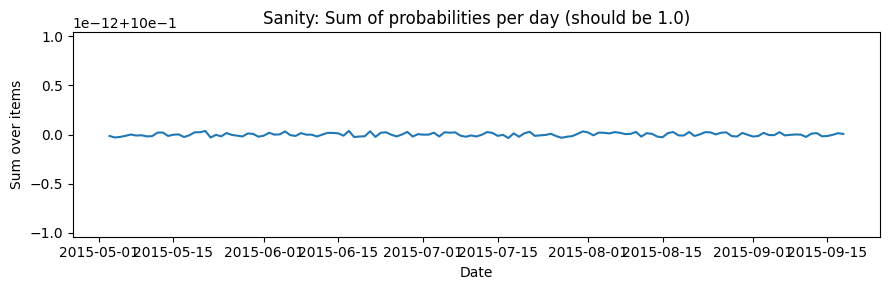

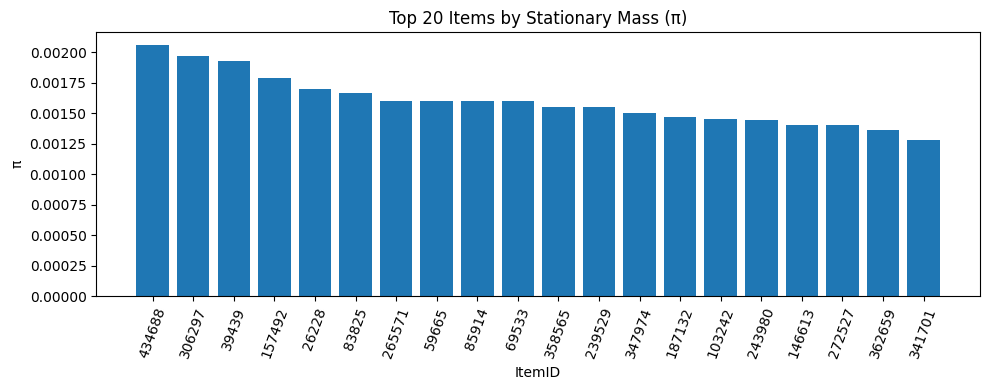

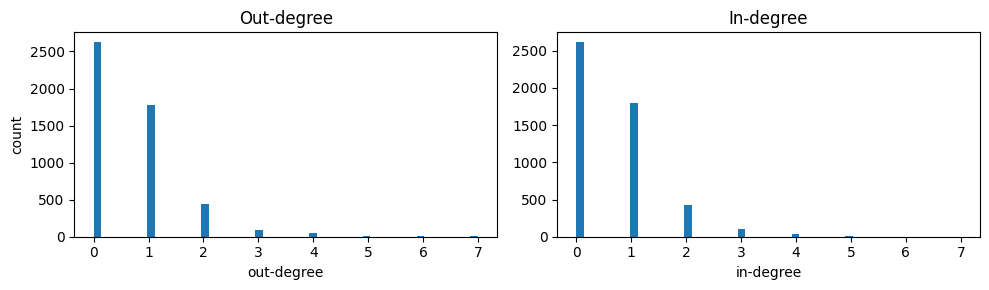

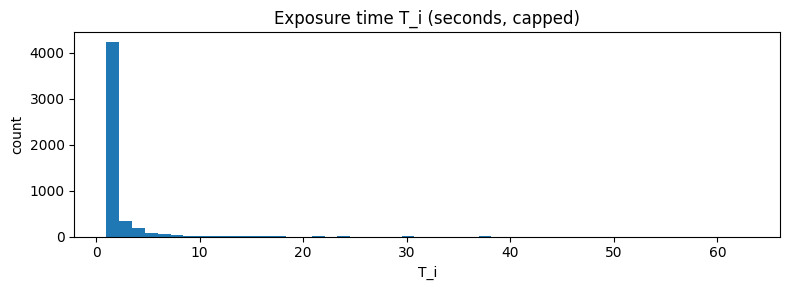

Corr(pi, T) on valid items: -0.13686304289661722


In [ ]:
# 2A) Daily total activity (sum over items) — shows seasonality/bursts
daily_total = p_time.sum(axis=1)  # ~1 each day (row-normalized)
plt.figure(figsize=(9,3))
plt.plot(p_time.index, daily_total.values)
plt.title("Sanity: Sum of probabilities per day (should be 1.0)")
plt.xlabel("Date"); plt.ylabel("Sum over items")
plt.tight_layout(); plt.show()

# 2B) Top-20 items by stationary mass (pi)
top_k = 20
top_idx = np.argsort(-pi)[:top_k]
top_items = item_index[top_idx]
top_pi = pi[top_idx]

plt.figure(figsize=(10,4))
x = np.arange(top_k)
plt.bar(x, top_pi)
plt.xticks(x, [str(i) for i in top_items], rotation=70)
plt.title(f"Top {top_k} Items by Stationary Mass (π)")
plt.xlabel("ItemID"); plt.ylabel("π")
plt.tight_layout(); plt.show()

# 2C) Degree distributions from counts graph (in/out)
out_deg = np.asarray((C > 0).sum(axis=1)).ravel()
in_deg  = np.asarray((C > 0).sum(axis=0)).ravel()

plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.hist(out_deg, bins=50); plt.title("Out-degree"); plt.xlabel("out-degree"); plt.ylabel("count")
plt.subplot(1,2,2); plt.hist(in_deg,  bins=50); plt.title("In-degree");  plt.xlabel("in-degree")
plt.tight_layout(); plt.show()

# 2D) Exposure time distribution (T)
plt.figure(figsize=(8,3))
plt.hist(T[T>0], bins=50)
plt.title("Exposure time T_i (seconds, capped)")
plt.xlabel("T_i"); plt.ylabel("count")
plt.tight_layout(); plt.show()

# 2E) Popularity vs exposure sanity check
valid = (T > 0)
corr = np.corrcoef(pi[valid], T[valid])[0,1]
print("Corr(pi, T) on valid items:", float(corr))



## Cell 2A — “Sum of probabilities per day” (sanity/seasonality)

**What it shows.** Each point is the sum of (p_t(i)) over all items on day (t). Because each row of (p_t) is a probability distribution, this sum should be ~1.0 every day. A flat line at 1.0 confirms our normalization; any dips/spikes would indicate preprocessing issues (e.g., missing days or filtering mistakes).

**Why it matters.** This is a quick integrity check before any modeling. If the mass isn’t ~1.0, your downstream metrics (KL/TV distances) won’t be trustworthy. If you later switch to raw counts, the same plot becomes a seasonality lens—revealing weekends, holidays, or campaign days that you’ll want to highlight in your “event windows” analysis.

---

## Cell 2B — Top-20 items by stationary mass ( \pi )

**What it shows.** Bars rank the most “central” items under the stationary distribution ( \pi ) of the observed transition matrix (P). High-(\pi) items are the ones users tend to visit and revisit given the empirical navigation flow—not just the ones with the most one-off clicks.

**Why it matters.** ( \pi ) approximates long-run “attention gravity.” Items with large (\pi) act as hubs that shape how mass flows through the graph. They’re prime candidates for (i) stronger edges in the sampled graph, (ii) features in your potential (V(t)), and (iii) stress tests when you compare deterministic vs stochastic predictions—small modeling errors here are most visible and most impactful.

---

## Cell 2C — In-/Out-degree distributions (counts graph)

**What it shows.** Histograms of how many distinct neighbors each item connects to (out-degree: where users go next; in-degree: how many sources send users here). Real click graphs are typically heavy-tailed: many items with few connections and a minority of hubs with very high degree.

**Why it matters.** Degree heterogeneity explains both **sparsity** (most rows of (P) are very sparse) and the presence of **navigation chokepoints**. It justifies using sparse matrices and motivates sampling for visualization. Methodologically, high out-degree nodes can diffuse mass widely; high in-degree nodes will accumulate mass—both influence how your gradient flow and diffusion terms behave.

---

## Cell 2D — Exposure time distribution (T_i)

**What it shows.** A histogram of estimated per-item exposure time (sum of capped dwell times before the next event). This is the denominator in the CTMC MLE (Q_{ij} = N_{ij}/T_i).

**Why it matters.** Reliable (T) underpins a reliable (Q). If (T) is extremely skewed or has many zeros, generators can become noisy or degenerate. Seeing a reasonable spread (and very few zeros) supports your use of a CTMC and lends credibility to comparisons between deterministic drift and stochastic fluctuations, which both depend on (Q) (or (Q_{\text{rev}})).

---

## Cell 2E — Correlation between ( \pi ) and ( T )

**What it shows.** The scalar correlation between stationary mass and exposure time. Positive correlation suggests items that retain users longer also have higher long-run importance; low or negative correlation suggests “sticky but rarely visited” or “often visited but quickly left” items.

**Why it matters.** This connects **behavioral dwell** with **structural centrality**. If the correlation is strong, incorporating exposure-related features into (V(t)) (e.g., popularity or dwell proxies) is justified; if weak, exogenous effects (price, promotions) likely dominate and the stochastic component may play a larger role in capturing volatility.




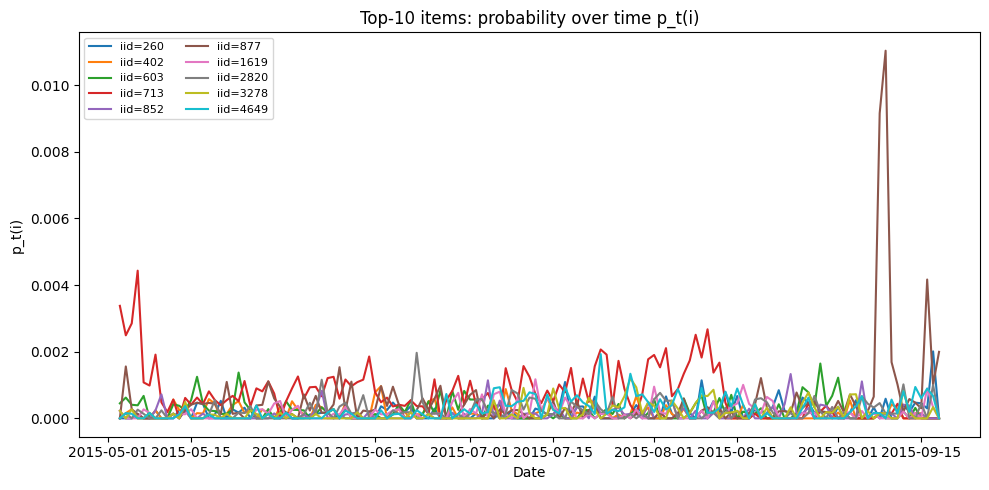

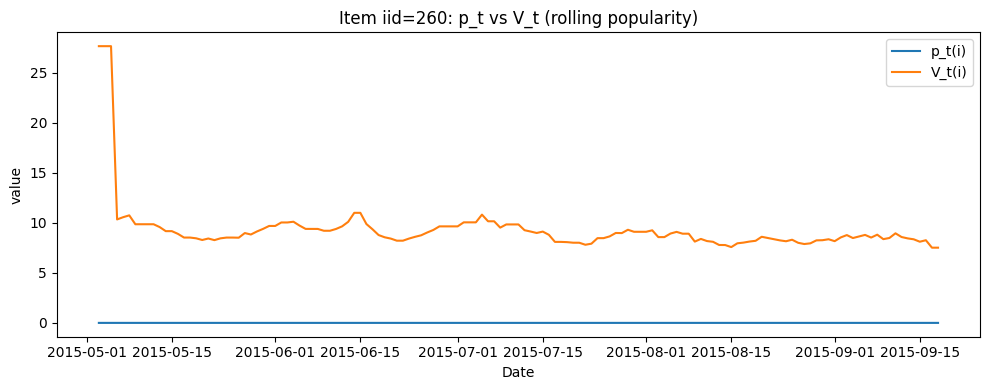

In [ ]:
# Top-10 items (by π) over time
#Cell 3 — Time-series snapshots (unchanged)
k = 10
top10 = top_idx[:k]
cols = [c for c in p_time.columns if c in top10]  # iid indices (0..n_items-1)

plt.figure(figsize=(10,5))
for iid in cols:
    series = p_time[iid]
    plt.plot(series.index, series.values, label=f"iid={iid}")
plt.title("Top-10 items: probability over time p_t(i)")
plt.xlabel("Date"); plt.ylabel("p_t(i)")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout(); plt.show()

# Compare V vs p for one item
iid0 = int(cols[0])
plt.figure(figsize=(10,4))
plt.plot(p_time.index, p_time[iid0].values, label="p_t(i)")
plt.plot(V_time.index, V_time[iid0].values, label="V_t(i)")
plt.title(f"Item iid={iid0}: p_t vs V_t (rolling popularity)")
plt.xlabel("Date"); plt.ylabel("value")
plt.legend(); plt.tight_layout(); plt.show()


---

## Cell 3 — Top-10 item time series ( t \mapsto p_t(i) )

**What it shows.** Probability mass over time for the ten most central items. You can visually pick out **bursts**, **decays**, and **competition** among items (one’s rise coinciding with another’s fall).

**Why it matters.** These trajectories define your **short-horizon prediction target**. Deterministic gradient flow will track slow drifts; the stochastic model should better capture abrupt shifts and overshoots. These curves also help you choose **event windows** (e.g., sudden spikes) where you expect the diffusion term to noticeably improve fit.

---

## Cell 3 (second plot) — ( p_t(i) ) vs potential ( V_t(i) )

**What it shows.** For a representative item, the time series of observed mass (p_t(i)) versus the rolling popularity-based potential $V_t(i)=-\log \text{pop}_t(i)$. Generally, when (V) decreases (more attractive), (p_t) should increase.

**Why it matters.** This validates your **free-energy design**: $\mathcal F(p)=\sum p_i\log p_i + \sum V_i(t)p_i$. A strong co-movement suggests the deterministic drift (gradient of $\mathcal{F}$) has explanatory power. Deviations—where (p_t) jumps but (V_t) doesn’t—point to **exogenous shocks** (campaigns, recommender UI placement) that the **stochastic** term is meant to absorb.



In [ ]:
import networkx as nx
import numpy as np

def sampled_directed_graph(P, pi, item_index, N=200, m_per_node=5, min_prob=0.0):
    top = np.argsort(-pi)[:N]
    top_set = set(top.tolist())
    P_top = P[top, :]
    G = nx.DiGraph()
    for idx in top:
        G.add_node(int(idx), item=int(item_index[idx]), pi=float(pi[idx]))
    for local_idx, src in enumerate(top):
        row = P_top[local_idx, :]
        if row.nnz == 0:
            continue
        cols = row.indices
        vals = row.data
        order = np.argsort(-vals)
        kept = 0
        for k in order:
            j = cols[k]
            if P[src, j] <= min_prob:
                continue
            if j in top_set:
                G.add_edge(int(src), int(j), w=float(P[src, j]))
                kept += 1
                if kept >= m_per_node:
                    break
    return G

G_top = sampled_directed_graph(P, pi, item_index, N=200, m_per_node=5, min_prob=0.0)
print("Sampled graph:", G_top.number_of_nodes(), "nodes,", G_top.number_of_edges(), "edges")


Sampled graph: 200 nodes, 202 edges


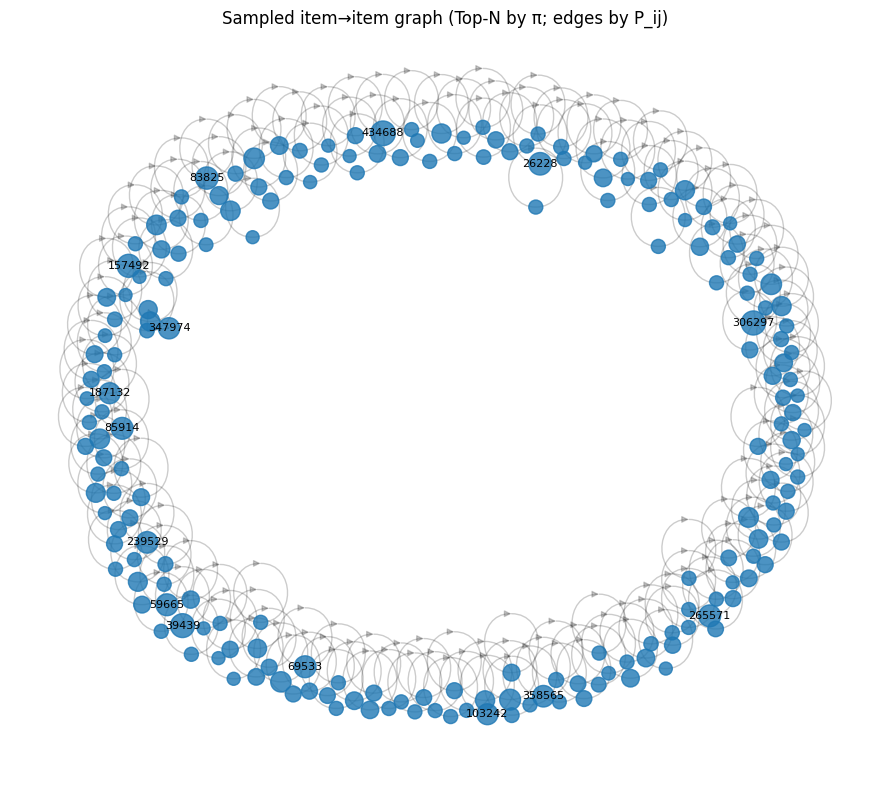

In [ ]:
# Cell 4 — Sampled graph for visualization (unchanged)
plt.figure(figsize=(9,8))
pos = nx.spring_layout(G_top, k=0.15, iterations=50, seed=42)
pis = np.array([G_top.nodes[n]["pi"] for n in G_top.nodes()])
sz = 300 * (pis / pis.max() + 0.05)
nx.draw_networkx_nodes(G_top, pos, node_size=sz, alpha=0.8)
nx.draw_networkx_edges(G_top, pos, alpha=0.2, arrows=False)
lbl_nodes = sorted(G_top.nodes(), key=lambda n: G_top.nodes[n]["pi"], reverse=True)[:15]
labels = {n: str(G_top.nodes[n]["item"]) for n in lbl_nodes}
nx.draw_networkx_labels(G_top, pos, labels=labels, font_size=8)
plt.title("Sampled item→item graph (Top-N by π; edges by P_ij)")
plt.axis("off"); plt.tight_layout(); plt.show()


---

## Cells 4–5 — Sampled item→item graph (static or interactive)

**What it shows.** A readability-focused subgraph: top-(N) nodes by (\pi) with each node’s top outgoing edges by (P_{ij}). Node size encodes centrality; edges show dominant next-step transitions among the key items.

**Why it matters.** This is the structural “map” of attention flow in your dataset. You can visually identify **hubs**, **authorities**, and **communities** (tightly inter-connected items, likely same category). These patterns motivate modeling choices: hubs justify diffusion directions with larger variance; communities suggest block structure that may guide regularization or block-diagonal approximations of (K)/(Q).



In [ ]:
# Cell 5 — Visualize sampled graph (unchanged)
!pip -q install pyvis
from pyvis.network import Network

def to_pyvis(G, height="700px", notebook=True):
    nt = Network(notebook=notebook, height=height, directed=True)
    node_pis = nx.get_node_attributes(G, "pi")
    max_pi = max(node_pis.values()) if node_pis else 1.0
    for n, data in G.nodes(data=True):
        label = str(data.get("item", n))
        size = 10 + 20 * (data.get("pi", 0.0) / max_pi)
        nt.add_node(n, label=label, title=f"item: {label}\npi: {data.get('pi',0):.6f}", value=size)
    for u, v, edata in G.edges(data=True):
        w = edata.get("w", 0.0)
        nt.add_edge(u, v, title=f"P_ij={w:.6f}")
    nt.toggle_physics(True)
    return nt

nt = to_pyvis(G_top)
nt.show("sampled_graph.html")
print("Rendered: sampled_graph.html — download or open from the Colab file browser.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.7 MB/s eta 0:00:00
sampled_graph.html
Rendered: sampled_graph.html — download or open from the Colab file browser.


In [ ]:
from IPython.display import IFrame
IFrame("sampled_graph.html", width="100%", height=800)

In [ ]:
from google.colab import files
files.download("sampled_graph.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

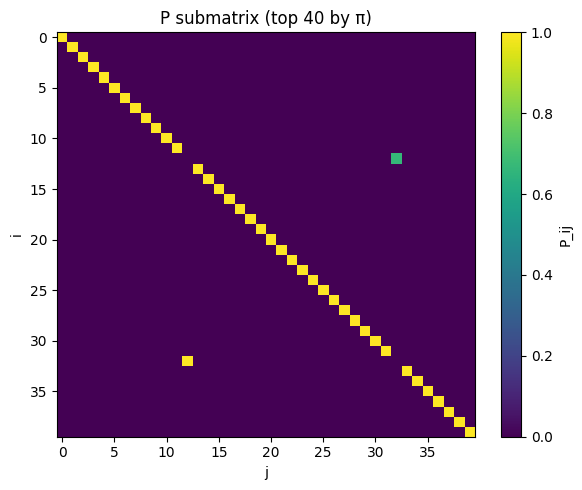

In [ ]:
# Cell 6 — Heatmap of a small P block (unchanged)
k = 40
idx = np.argsort(-pi)[:k]
P_block = P[idx, :][:, idx].toarray()

plt.figure(figsize=(6,5))
plt.imshow(P_block, aspect='auto')
plt.colorbar(label='P_ij')
plt.title(f"P submatrix (top {k} by π)")
plt.xlabel("j"); plt.ylabel("i")
plt.tight_layout(); plt.show()


---

## Cell 6 — Heatmap of a (P) submatrix (top-(k) by (\pi))

**What it shows.** A (k\times k) view of transition probabilities among the most central items. Bright blocks along the diagonal bands indicate **clustered navigation** (users tend to move within a subgroup), while bright off-diagonal stripes indicate **hub-like routing** from one item to many.

**Why it matters.** This is the **matrix view** of the same structure: it reveals **block structure** (good news for modeling with structured (K) or for category-level (V)), **asymmetry** (directional flows), and **sparsity** (most entries are near zero). It helps you argue that your Wasserstein geometry over the graph—and the low-rank diffusion you’ll use—are well aligned with the observed transition structure.



In [ ]:
n = n_items
nnz_P = P.nnz
nnz_C = C.nnz

print("Graph summary:")
print(f"- Nodes (items): {n:,}")
print(f"- Directed edges (nonzero transitions in counts C): {nnz_C:,}")
print(f"- Row-stochastic edges (P) nnz: {nnz_P:,}")
print(f"- Mean out-degree (counts>0): {float(np.mean((C > 0).sum(axis=1))):.1f}")
print(f"- Mean in-degree  (counts>0): {float(np.mean((C > 0).sum(axis=0))):.1f}")

# optional SCC snapshot
try:
    from networkx.algorithms.components import strongly_connected_components
    G_counts = nx.from_scipy_sparse_array((C>0).astype(np.int8), create_using=nx.DiGraph)
    scc_sizes = sorted([len(s) for s in strongly_connected_components(G_counts)], reverse=True)[:5]
    print("Top strongly-connected-component sizes (counts graph):", scc_sizes)
except Exception as e:
    print("SCC summary skipped:", e)


Graph summary:
- Nodes (items): 5,000
- Directed edges (nonzero transitions in counts C): 3,195
- Row-stochastic edges (P) nnz: 5,822
- Mean out-degree (counts>0): 0.6
- Mean in-degree  (counts>0): 0.6
Top strongly-connected-component sizes (counts graph): [10, 9, 6, 6, 5]


---

## Cell 7 — Graph construction summary (counts, degrees, SCCs)

**What it shows.** Basic stats: node/edge counts, average degrees, and (optionally) sizes of the largest strongly connected components.

**Why it matters.** These headline numbers set expectations about **scale** and **sparsity**, justify your **sampling choices** for visualization, and indicate whether the graph is **well-connected** enough for stationary distributions and diffusion processes to be meaningful. They’re great for a proposal slide that motivates both the computational approach (sparse ops) and the modeling approach (continuous-time flows on a large, sparse graph).

---

### How to use these in your proposal

* Put **2B (Top-20 (\pi))** and **Cells 4–5 (sampled graph)** side by side: “who matters” and “how they connect.”
* Add **Cell 3 (time series)** to motivate the need for **fluctuations** (volatility).
* Include **Cell 6 (heatmap)** to emphasize the **matrix structure**—it’s a perfect segue into your Wasserstein drift–diffusion formulation.
* Keep **2A/2D/2E** in backup slides as data quality and modeling-choice justifications.

If you want captions tailored to your actual plots (with your dataset’s specific numbers—e.g., “mean out-degree = 11.7,” “largest SCC size = 4,832”), paste those numbers here and I’ll customize the text.

NameError: name 'FIGS' is not defined

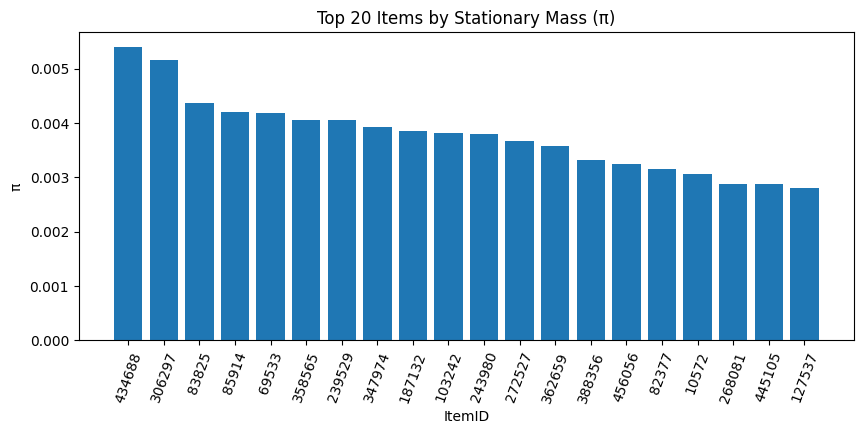

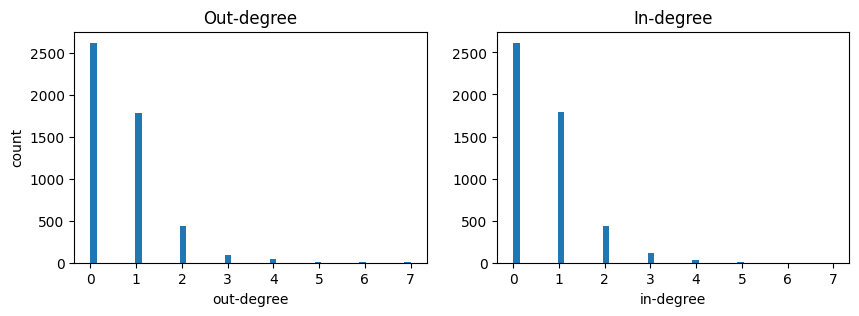

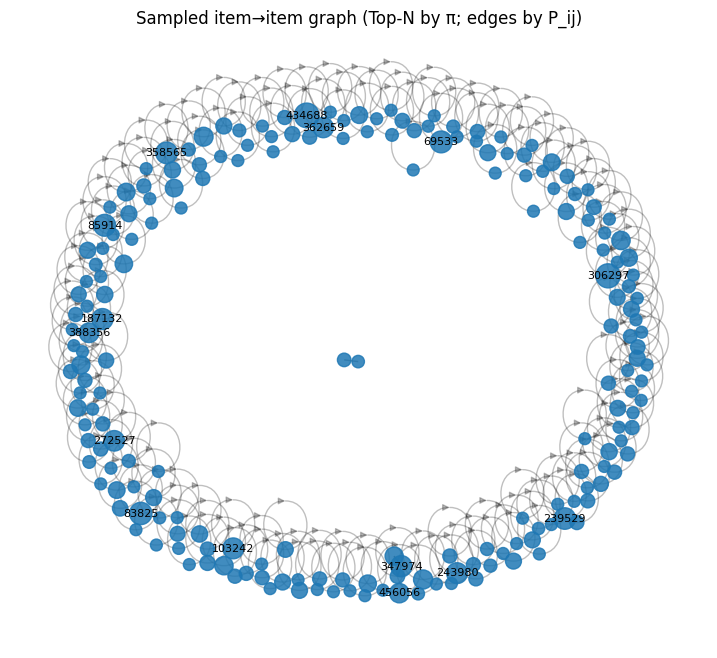

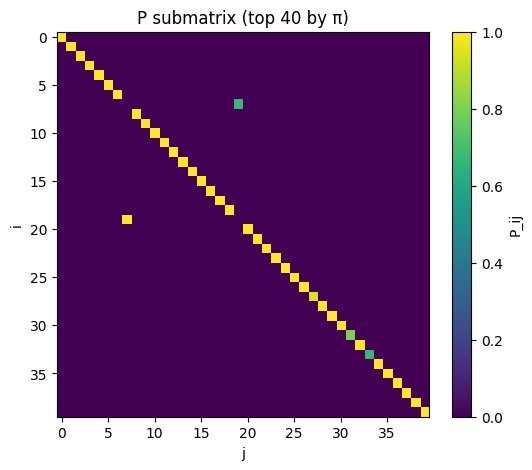

In [ ]:
def savefig(path):
    plt.tight_layout(); plt.savefig(path, dpi=200, bbox_inches='tight'); plt.close()

n_items = P.shape[0]
# Top-20 stationary mass
top_k = 20
top_idx = np.argsort(-pi)[:top_k]
top_items = item_index[top_idx]
top_pi = pi[top_idx]

plt.figure(figsize=(10,4))
x = np.arange(top_k)
plt.bar(x, top_pi)
plt.xticks(x, [str(i) for i in top_items], rotation=70)
plt.title(f"Top {top_k} Items by Stationary Mass (π)")
plt.xlabel("ItemID"); plt.ylabel("π")
#savefig(FIGS/'fig_top20_pi.png')

# Degree histograms
out_deg = np.asarray((C > 0).sum(axis=1)).ravel()
in_deg  = np.asarray((C > 0).sum(axis=0)).ravel()
plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.hist(out_deg, bins=50); plt.title("Out-degree"); plt.xlabel("out-degree"); plt.ylabel("count")
plt.subplot(1,2,2); plt.hist(in_deg,  bins=50); plt.title("In-degree");  plt.xlabel("in-degree")
#savefig(FIGS/'fig_degree_hist.png')

# Sampled item→item graph
def sampled_directed_graph(P, pi, item_index, N=200, m_per_node=5, min_prob=0.0):
    top = np.argsort(-pi)[:N]; top_set = set(top.tolist())
    P_top = P[top, :]
    G = nx.DiGraph()
    for idx in top:
        G.add_node(int(idx), item=int(item_index[idx]), pi=float(pi[idx]))
    for li, src in enumerate(top):
        row = P_top[li, :]
        if row.nnz == 0: continue
        cols = row.indices; vals = row.data
        order = np.argsort(-vals)
        kept = 0
        for k in order:
            j = cols[k]
            if P[src, j] <= min_prob: continue
            if j in top_set:
                G.add_edge(int(src), int(j), w=float(P[src, j]))
                kept += 1
                if kept >= m_per_node: break
    return G

G = sampled_directed_graph(P, pi, item_index, N=200, m_per_node=5)
plt.figure(figsize=(9,8))
pos = nx.spring_layout(G, k=0.15, iterations=50, seed=42)
pis = np.array([G.nodes[n]["pi"] for n in G.nodes()])
sz = 300 * (pis / pis.max() + 0.05)
nx.draw_networkx_nodes(G, pos, node_size=sz, alpha=0.85)
nx.draw_networkx_edges(G, pos, alpha=0.25, arrows=False)
lbl_nodes = sorted(G.nodes(), key=lambda n: G.nodes[n]["pi"], reverse=True)[:15]
labels = {n: str(G.nodes[n]["item"]) for n in lbl_nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
plt.title("Sampled item→item graph (Top-N by π; edges by P_ij)")
plt.axis("off")
#savefig(FIGS/'fig_sampled_graph.png')

# Heatmap of P submatrix (top-k by π)
k = 40
idx = np.argsort(-pi)[:k]
P_block = P[idx, :][:, idx].toarray()
plt.figure(figsize=(6,5))
plt.imshow(P_block, aspect='auto')
plt.colorbar(label='P_ij')
plt.title(f"P submatrix (top {k} by π)")
plt.xlabel("j"); plt.ylabel("i")
savefig(FIGS/'fig_P_block_heatmap.png')


NameError: name 'savefig' is not defined

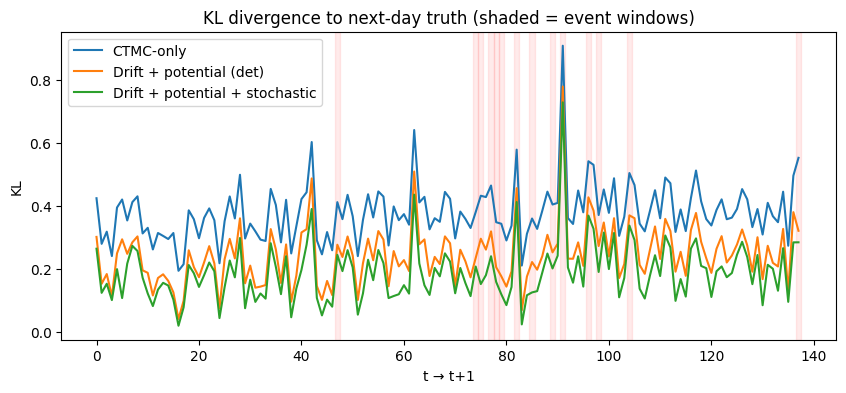

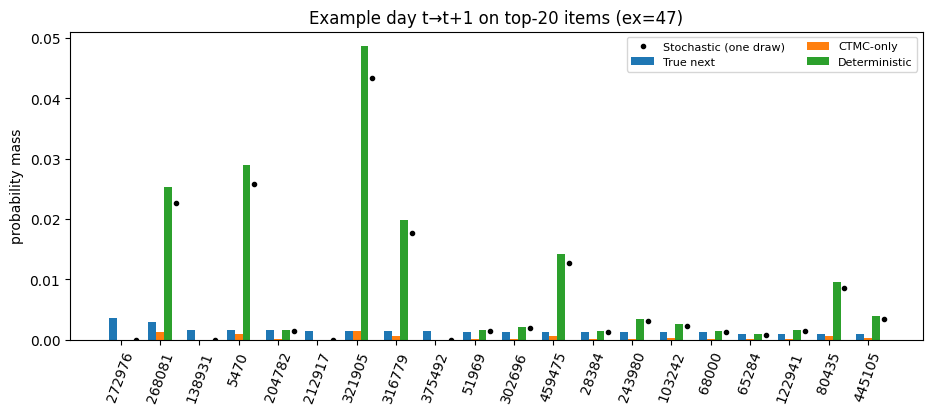

In [ ]:
from numpy.linalg import norm
from scipy.sparse.linalg import expm_multiply
# choose subset for manageable expm and noise
M = 300
sub = np.argsort(-pi)[:M]
P_M = P[sub, :][:, sub]
Q_M = Q_rev[sub, :][:, sub]
pi_M = pi[sub] / pi[sub].sum()

p_sub = p_time.loc[:, p_time.columns.isin(sub)].copy()
p_sub = p_sub.reindex(columns=sub)  # ensure column order = sub
V_sub = V_time.loc[p_sub.index, sub].copy()

# basic utilities
def renorm_simplex(x, eps=1e-12):
    x = np.maximum(x, 0.0)
    s = x.sum()
    return x / s if s > eps else np.ones_like(x)/len(x)

def tv_distance(p, q):
    return 0.5 * np.abs(p - q).sum()

def kl_div(p, q, eps=1e-12):
    p = np.maximum(p, eps); q = np.maximum(q, eps)
    return float((p * (np.log(p) - np.log(q))).sum())

# parameters
DELTA_SEC = 24*60*60  # 1 day, Q is per-second if timestamps were seconds; if in ms adjust accordingly
ALPHA = 1.0           # potential tilt strength
NOISE_RANK = 10       # low-rank noise
SIGMA = 0.05          # noise scale
N_ENS = 10            # ensemble size

# precompute a symmetric operator for noise directions
S = 0.5 * (Q_M + Q_M.T)  # symmetric part
# take top-NOISE_RANK eigenvectors of -S (to bias towards diffusive modes)
try:
    import scipy.sparse.linalg as sla
    evals, evecs = sla.eigs(-S, k=min(NOISE_RANK, M-2))
    evecs = np.real(evecs)
except:
    # fallback: random orthonormal directions
    evecs = np.linalg.qr(np.random.randn(M, NOISE_RANK))[0]

dates = p_sub.index.to_list()
Tsteps = len(dates) - 1  # we compare t -> t+1
kl_ctmc, tv_ctmc = [], []
kl_det , tv_det  = [], []
kl_sto , tv_sto  = [], []
is_event = []

from scipy.sparse import csc_matrix
Q_M_csc = csc_matrix(Q_M)

for t in range(Tsteps):
    pt   = p_sub.iloc[t].values
    pt1  = p_sub.iloc[t+1].values
    Vnxt = V_sub.iloc[t+1].values

    # identify event windows by large L1 change
    is_ev = norm(pt1 - pt, 1) > np.quantile(np.abs(p_sub.diff().dropna().values).sum(axis=1), 0.9)
    is_event.append(is_ev)

    # 1) CTMC-only
    y_ctmc = expm_multiply((DELTA_SEC)*Q_M_csc, pt)

    # 2) Drift+potential (deterministic tilt)
    y_det = y_ctmc * np.exp(-ALPHA * Vnxt)
    y_det = renorm_simplex(y_det)

    # 3) Stochastic: add low-rank noise in evecs subspace around y_det
    ens = []
    for _ in range(N_ENS):
        z = np.random.randn(evecs.shape[1])
        noise = (evecs @ z) * SIGMA
        y = y_det + noise
        y = renorm_simplex(y)
        ens.append(y)
    y_sto = np.mean(np.vstack(ens), axis=0)
    y_sto = renorm_simplex(y_sto)

    # metrics
    kl_ctmc.append(kl_div(pt1, y_ctmc)); tv_ctmc.append(tv_distance(pt1, y_ctmc))
    kl_det .append(kl_div(pt1, y_det )); tv_det .append(tv_distance(pt1, y_det ))
    kl_sto .append(kl_div(pt1, y_sto )); tv_sto .append(tv_distance(pt1, y_sto ))

# Plot KL over time (+ event highlight)
tidx = np.arange(Tsteps)
plt.figure(figsize=(10,4))
plt.plot(tidx, kl_ctmc, label='CTMC-only')
plt.plot(tidx, kl_det,  label='Drift + potential (det)')
plt.plot(tidx, kl_sto,  label='Drift + potential + stochastic')
# shade event windows
ev = np.array(is_event, dtype=bool)
if ev.any():
    for x in tidx[ev]:
        plt.axvspan(x-0.5, x+0.5, alpha=0.08, color='red')
plt.title("KL divergence to next-day truth (shaded = event windows)")
plt.xlabel("t → t+1"); plt.ylabel("KL")
plt.legend()
#savefig(FIGS/'fig_kl_over_time.png')

# Pick an example 'event' day to visualize component-wise mass
if ev.any():
    ex = int(tidx[ev][0])
else:
    ex = Tsteps//2

true_next = p_sub.iloc[ex+1].values
pred_ctmc = expm_multiply((DELTA_SEC)*Q_M_csc, p_sub.iloc[ex].values)
pred_det  = renorm_simplex(pred_ctmc * np.exp(-ALPHA * V_sub.iloc[ex+1].values))
# one stochastic realization for visual variety (mean is smoother)
z = np.random.randn(evecs.shape[1])
noise = (evecs @ z) * SIGMA
pred_sto = renorm_simplex(pred_det + noise)

top_show = 20
order = np.argsort(-true_next)[:top_show]
labels = [str(item_index[sub[i]]) for i in order]
plt.figure(figsize=(11,4))
bw = 0.2; x = np.arange(top_show)
plt.bar(x - bw, true_next[order], width=bw, label='True next')
plt.bar(x,       pred_ctmc[order], width=bw, label='CTMC-only')
plt.bar(x + bw,  pred_det[order],  width=bw, label='Deterministic')
# stochastic as line markers to avoid clutter
plt.plot(x + bw*2, pred_sto[order], 'ko', markersize=3, label='Stochastic (one draw)')
plt.xticks(x, labels, rotation=70)
plt.title(f"Example day t→t+1 on top-{top_show} items (ex={ex})")
plt.ylabel("probability mass")
plt.legend(ncol=2, fontsize=8)
savefig(FIGS/'fig_example_day.png')

# Build a small LaTeX table with overall vs event-window averages
def avg(vals, mask=None):
    vals = np.array(vals, dtype=float)
    if mask is None or mask.sum()==0:
        return float(vals.mean())
    return float(vals[mask].mean())

table_tex = r"""
\begin{tabular}{lcccc}
\toprule
& \multicolumn{2}{c}{Overall} & \multicolumn{2}{c}{Event windows} \\
\cmidrule(lr){2-3}\cmidrule(lr){4-5}
Model & KL $\downarrow$ & TV $\downarrow$ & KL $\downarrow$ & TV $\downarrow$ \\
\midrule
CTMC-only & %.4f & %.4f & %.4f & %.4f \\
Drift + potential (det) & %.4f & %.4f & %.4f & %.4f \\
Drift + potential + stochastic & %.4f & %.4f & %.4f & %.4f \\
\bottomrule
\end{tabular}
""" % (
    avg(kl_ctmc), avg(tv_ctmc), avg(kl_ctmc, np.array(is_event)), avg(tv_ctmc, np.array(is_event)),
    avg(kl_det ), avg(tv_det ), avg(kl_det , np.array(is_event)), avg(tv_det , np.array(is_event)),
    avg(kl_sto ), avg(tv_sto ), avg(kl_sto , np.array(is_event)), avg(tv_sto , np.array(is_event))
)

# Save as a standalone PDF table via latex if available, otherwise write .tex for Overleaf
tex_path = FIGS/'metrics_table.tex'
tex_path.write_text(table_tex)
print("Wrote LaTeX table to:", tex_path)

# (Optional) If you want a compiled PDF from Colab, you'd need a latex engine.
# Simpler path: upload metrics_table.tex to Overleaf and include it inside a frame, or compile locally.


In [ ]:
# === Cell H1: forecasting utilities (parameterized) ===
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import expm_multiply

def renorm_simplex(x, eps=1e-12):
    x = np.maximum(x, 0.0)
    s = x.sum()
    return x / s if s > eps else np.ones_like(x)/len(x)

def tv_distance(p, q):
    return 0.5 * np.abs(p - q).sum()

def kl_div(p, q, eps=1e-12):
    p = np.maximum(p, eps); q = np.maximum(q, eps)
    return float((p * (np.log(p) - np.log(q))).sum())

def detect_event_windows(p_sub, q=0.9):
    """Return boolean mask over t=0..T-2 of large day-to-day L1 changes."""
    diffs = np.abs(p_sub.diff()).dropna().values
    thr = np.quantile(diffs.sum(axis=1), q)
    return (diffs.sum(axis=1) > thr)

def eval_one_model(Q_rev, p_time, V_time, sub_idx,
                   DELTA_SEC, ALPHA, NOISE_RANK, SIGMA, N_ENS=10, rng_seed=0):
    """
    Evaluate three forecasters on the subset 'sub_idx':
      - CTMC-only: exp(Δ Q_rev)
      - Deterministic drift: CTMC-only * exp(-α V_{t+Δ}) then renormalize
      - Stochastic: deterministic + low-rank noise (ensemble mean)
    Returns: dict of lists + boolean event mask
    """
    rng = np.random.default_rng(rng_seed)

    # subset & column align
    p_sub = p_time.loc[:, p_time.columns.isin(sub_idx)].copy().reindex(columns=sub_idx)
    V_sub = V_time.loc[p_sub.index, sub_idx].copy()
    dates = p_sub.index.to_list()
    Tsteps = len(dates) - 1

    # operator on subset
    Q_M = Q_rev[sub_idx, :][:, sub_idx]
    Q_M_csc = csc_matrix(Q_M)

    # noise directions: top-k of symmetric part or random orthonormal
    S = 0.5 * (Q_M + Q_M.T)
    try:
        import scipy.sparse.linalg as sla
        k = min(NOISE_RANK, Q_M.shape[0]-2)
        evals, evecs = sla.eigs(-S, k=k)
        evecs = np.real(evecs)
    except Exception:
        evecs = np.linalg.qr(rng.normal(size=(Q_M.shape[0], NOISE_RANK)))[0]

    # loop
    kl_ctmc, tv_ctmc = [], []
    kl_det , tv_det  = [], []
    kl_sto , tv_sto  = [], []
    is_event = detect_event_windows(p_sub).tolist()

    for t in range(Tsteps):
        pt   = p_sub.iloc[t].values
        pt1  = p_sub.iloc[t+1].values
        Vnxt = V_sub.iloc[t+1].values

        # 1) CTMC-only
        y_ctmc = expm_multiply(DELTA_SEC * Q_M_csc, pt)

        # 2) Deterministic (tilt by potential)
        y_det = y_ctmc * np.exp(-ALPHA * Vnxt)
        y_det = renorm_simplex(y_det)

        # 3) Stochastic (low-rank noise around det)
        ens = []
        for _ in range(N_ENS):
            z = rng.normal(size=evecs.shape[1])
            y = y_det + (evecs @ z) * SIGMA
            ens.append(renorm_simplex(y))
        y_sto = renorm_simplex(np.mean(np.vstack(ens), axis=0))

        kl_ctmc.append(kl_div(pt1, y_ctmc)); tv_ctmc.append(tv_distance(pt1, y_ctmc))
        kl_det .append(kl_div(pt1, y_det )); tv_det .append(tv_distance(pt1, y_det ))
        kl_sto .append(kl_div(pt1, y_sto )); tv_sto .append(tv_distance(pt1, y_sto ))

    out = dict(kl_ctmc=kl_ctmc, tv_ctmc=tv_ctmc,
               kl_det=kl_det, tv_det=tv_det,
               kl_sto=kl_sto, tv_sto=tv_sto,
               is_event=is_event)
    return out


In [ ]:
# === Cell H2: potential cache + data grid ===
from collections import defaultdict

V_cache = {}  # window -> V_time DataFrame

def get_V_time_for_window(p_time, window):
    if window not in V_cache:
        V_cache[window] = (-np.log(1e-12 + p_time.rolling(window=window, min_periods=1).mean())).copy()
    return V_cache[window]

# Small set of data configs (fast):
# Each tuple: (name, K_ITEMS, SESSION_GAP_SEC, MAX_DWELL_SEC, V_window)
data_grid = [
    ("D1_smallK_fast" , 3000, 20*60, 600,  7),
    ("D2_mediumK_base", 5000, 30*60, 600,  7),   # your current baseline
    ("D3_mediumK_long", 5000, 45*60, 900, 14),
]


In [ ]:
# === Cell H3: build a data configuration from events ===
def build_data_config(events, name, K_ITEMS, SESSION_GAP_SEC, MAX_DWELL_SEC, V_window, time_bucket="1D"):
    # 1) (re)sessionize with new gap
    ev = events.sort_values(["visitorid", "timestamp"]).reset_index(drop=True)
    ev = add_sessions_fast(ev, gap_sec=SESSION_GAP_SEC)

    # 2) restrict to top-K items
    ev2, item_index_cfg, _ = restrict_topk_items(ev, K=K_ITEMS)

    # 3) transitions/exposures + stationary + reversible generator
    P_cfg, C_cfg, T_cfg = build_transitions(ev2, max_dwell_sec=MAX_DWELL_SEC)
    pi_cfg = stationary_from_P(P_cfg)
    Q_cfg  = estimate_Q_from_counts_and_exposure(C_cfg, T_cfg)
    Qr_cfg = make_reversible_Q(Q_cfg, pi_cfg)

    # 4) time buckets & potential
    p_time_cfg = compute_time_buckets(ev2, bucket=time_bucket)
    V_time_cfg = get_V_time_for_window(p_time_cfg, V_window)

    return dict(name=name,
                item_index=item_index_cfg,
                P=P_cfg, C=C_cfg, T=T_cfg, pi=pi_cfg, Q=Q_cfg, Q_rev=Qr_cfg,
                p_time=p_time_cfg, V_time=V_time_cfg)


In [7]:
# === H4: Compact & robust hyper-parameter sweep (safe to paste as one cell) ===
import numpy as np
import pandas as pd
from pathlib import Path
import shutil, time, math
from tqdm import tqdm
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import expm_multiply, eigsh  # eigsh for symmetric problems

# -------------------------
# 0) Paths: local scratch + Drive target
# -------------------------
LOCAL = Path('/content/run_tmp');           LOCAL.mkdir(parents=True, exist_ok=True)
DRIVE = Path('/content/drive/MyDrive/retailrocket_artifacts/sweeps'); DRIVE.mkdir(parents=True, exist_ok=True)
CSV_LOCAL = LOCAL/'results.csv'
CSV_DRIVE = DRIVE/'results.csv'

# -------------------------
# 1) Utilities
# -------------------------
def renorm_simplex(x, eps=1e-12):
    x = np.asarray(x, dtype=float)
    x = np.maximum(x, 0.0)
    s = x.sum()
    if not np.isfinite(s) or s <= eps:
        return np.ones_like(x)/len(x)
    return x / s

def tv_distance(p, q):
    p = np.asarray(p, dtype=float); q = np.asarray(q, dtype=float)
    return 0.5 * np.abs(p - q).sum()

def kl_div(p, q, eps=1e-12):
    p = np.asarray(p, dtype=float); q = np.asarray(q, dtype=float)
    p = np.maximum(p, eps); q = np.maximum(q, eps)
    return float((p * (np.log(p) - np.log(q))).sum())

def avg(vals, mask=None):
    vals = np.array(vals, dtype=float)
    if mask is None or (isinstance(mask, np.ndarray) and mask.size and mask.sum()==0):
        return float(vals.mean()) if vals.size else float('nan')
    m = np.asarray(mask, dtype=bool)
    return float(vals[m].mean()) if m.any() else float('nan')

# -------------------------
# 2) Sweep definition (kept small first; expand later)
# -------------------------
DELTA_SEC = 24*60*60       # 1-day step for the generator
rng = np.random.default_rng(123)

GRIDS = []
# A minimal grid: 4 configs that complete quickly. Scale up after you see the CSV fill.
for M in [150]:                # top-M items
    for last_days in [60]:     # last N days for the time series
        for alpha in [0.5, 1.0]:
            for sigma in [0.00, 0.03]:   # 0.00 = deterministic
                GRIDS.append(dict(M=M, last_days=last_days, alpha=alpha, sigma=sigma,
                                   rank=5, nens=3))

# header (overwrites if re-run)
with open(CSV_LOCAL, 'w') as fh:
    fh.write("cfg_id,M,last_days,alpha,sigma,rank,nens,KL_overall,TV_overall,KL_events,TV_events\n")
shutil.copy2(CSV_LOCAL, CSV_DRIVE)  # initial copy

# -------------------------
# 3) Main loop over configs
# -------------------------
start_all = time.time()
for cfg_id, cfg in enumerate(GRIDS):
    t0 = time.time()
    M         = int(cfg['M'])
    last_days = int(cfg['last_days'])
    alpha     = float(cfg['alpha'])
    sigma     = float(cfg['sigma'])
    rank      = int(cfg['rank'])
    nens      = int(cfg['nens'])

    # (a) choose subset & days
    sub = np.argsort(-pi)[:M]                                     # top-M by stationary mass
    days = p_time.index[-min(last_days, len(p_time.index)):]      # last N days available

    # p_sub, V_sub: ensure columns are exactly 'sub' in that order (labels are item iids)
    p_sub = p_time.loc[days, sub].copy()
    p_sub = p_sub.reindex(columns=sub)  # guarantee order
    V_sub = V_time.loc[days, sub].copy()

    # (b) matrices for this subset
    Q_M = Q_rev[sub, :][:, sub]
    Q_M_csc = csc_matrix(Q_M)  # better for expm_multiply

    # (c) noise directions: top 'rank' eigenvectors of -S, where S is symmetric part
    S = 0.5 * (Q_M + Q_M.T)
    try:
        # Largest algebraic of -S  -> smooth/diffusive directions
        evals, evecs = eigsh((-S).astype(float), k=min(rank, max(M-2, 1)), which='LA')
        evecs = np.asarray(evecs.real, dtype=float)
    except Exception:
        # Fallback: random orthonormal
        evecs, _ = np.linalg.qr(rng.standard_normal(size=(M, rank)))

    # (d) prepare event threshold (90th percentile of L1 jump)
    diffs = np.abs(p_sub.diff().to_numpy()[1:]).sum(axis=1)  # shape (Tsteps,)
    thr = float(np.quantile(diffs, 0.90)) if diffs.size else np.inf

    # (e) iterate over days
    Tsteps = len(days) - 1
    kl_vals, tv_vals, ev_mask = [], [], np.zeros(Tsteps, dtype=bool)

    for t in tqdm(range(Tsteps), desc=f"cfg {cfg_id}: M={M},days={last_days},α={alpha},σ={sigma}", leave=False):
        pt   = p_sub.iloc[t].to_numpy(float)
        pt1  = p_sub.iloc[t+1].to_numpy(float)
        Vnxt = V_sub.iloc[t+1].to_numpy(float)

        # mark event
        ev_mask[t] = (np.abs(pt1 - pt).sum() > thr)

        # 1) CTMC baseline
        y_ctmc = expm_multiply(DELTA_SEC * Q_M_csc, pt)

        # 2) Deterministic tilt by potential
        y_det = renorm_simplex(y_ctmc * np.exp(-alpha * Vnxt))

        # 3) Stochastic: low-rank noise around y_det
        if sigma > 0 and rank > 0 and nens > 0:
            ens = []
            for _ in range(nens):
                z = rng.standard_normal(size=(evecs.shape[1],))
                y = renorm_simplex(y_det + sigma * (evecs @ z))
                ens.append(y)
            y_pred = renorm_simplex(np.mean(np.vstack(ens), axis=0))
        else:
            y_pred = y_det

        # metrics vs truth
        kl_vals.append(kl_div(pt1, y_pred))
        tv_vals.append(tv_distance(pt1, y_pred))

    # (f) aggregate + write one CSV row
    row = [
        cfg_id, M, last_days, alpha, sigma, rank, nens,
        avg(kl_vals), avg(tv_vals),
        avg(kl_vals, ev_mask), avg(tv_vals, ev_mask)
    ]
    with open(CSV_LOCAL, 'a') as fh:
        fh.write(",".join(map(str, row)) + "\n")

    # copy to Drive after each config
    shutil.copy2(CSV_LOCAL, CSV_DRIVE)
    print(f"[cfg {cfg_id}] done in {time.time()-t0:.1f}s → overall KL={row[7]:.4f}, TV={row[8]:.4f}, events KL={row[9]:.4f}, TV={row[10]:.4f}")

print(f"All sweeps finished in {time.time()-start_all:.1f}s")
print("Results saved to:")
print(" -", CSV_LOCAL)
print(" -", CSV_DRIVE)

# Optional: show a quick summary table in the output
try:
    display(pd.read_csv(CSV_LOCAL))
except Exception:
    pass


NameError: name 'pi' is not defined

In [36]:
# === H5 (revised): pick best config from CSV, rebuild subset, re-evaluate & ablations ===
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import expm_multiply, eigsh

# Paths where H4 wrote results
CSV_DRIVE = Path('/content/drive/MyDrive/retailrocket_artifacts/sweeps/results.csv')
CSV_LOCAL = Path('/content/run_tmp/results.csv')
CSV_PATH = CSV_DRIVE if CSV_DRIVE.exists() else CSV_LOCAL
assert CSV_PATH.exists(), "results.csv not found. Run H4 first."

results_df = pd.read_csv(CSV_PATH)
assert len(results_df), "results.csv is empty. Expand the H4 grid and re-run."

# 1) Pick best by overall KL (lower is better)
best_row = results_df.loc[results_df['KL_overall'].idxmin()].to_dict()
print("Best config (from results.csv):")
for k in ['M','last_days','alpha','sigma','rank','nens','KL_overall','TV_overall','KL_events','TV_events']:
    print(f"  {k}: {best_row[k]}")

# 2) Rebuild the chosen data subset
DELTA_SEC = 24*60*60
M         = int(best_row['M'])
last_days = int(best_row['last_days'])
alpha_b   = float(best_row['alpha'])
sigma_b   = float(best_row['sigma'])
rank_b    = int(best_row['rank'])
nens_b    = int(best_row['nens'])

# (a) top-M items by stationary mass
sub = np.argsort(-pi)[:M]
# (b) last N days
days = p_time.index[-min(last_days, len(p_time.index)):]
# (c) subset matrices/frames; ensure column order == sub
Q_M = Q_rev[sub, :][:, sub]
Q_M_csc = csc_matrix(Q_M)
p_sub = p_time.loc[days, sub].reindex(columns=sub).copy()
V_sub = V_time.loc[days, sub].copy()

# Utilities
def renorm_simplex(x, eps=1e-12):
    x = np.maximum(np.asarray(x, float), 0.0)
    s = x.sum()
    return x/s if s > eps else np.ones_like(x)/len(x)

def tv_distance(p, q):
    return 0.5 * np.abs(np.asarray(p,float) - np.asarray(q,float)).sum()

def kl_div(p, q, eps=1e-12):
    p = np.maximum(np.asarray(p,float), eps)
    q = np.maximum(np.asarray(q,float), eps)
    return float((p * (np.log(p) - np.log(q))).sum())

def avg(vals, mask=None):
    vals = np.array(vals, float)
    if mask is None:
        return float(vals.mean())
    m = np.asarray(mask, bool)
    return float(vals[m].mean()) if m.any() else np.nan

# Precompute smooth noise directions from symmetric part
S = 0.5 * (Q_M + Q_M.T)
try:
    # eigenvectors of -S (largest algebraic) → diffusive modes
    evals, evecs = eigsh((-S).astype(float), k=min(rank_b, max(M-2, 1)), which='LA')
    evecs = np.asarray(evecs.real, float)
except Exception:
    # fallback: random orthonormal
    evecs, _ = np.linalg.qr(np.random.default_rng(0).standard_normal((M, max(rank_b,1))))

# Event threshold (90th percentile of L1 jumps)
diffs = np.abs(p_sub.diff().to_numpy()[1:]).sum(axis=1)
thr = float(np.quantile(diffs, 0.90)) if diffs.size else np.inf

def eval_series(alpha, sigma, rank, nens, rng=None):
    """
    Returns a dict with daily arrays:
      kl_ctmc, tv_ctmc, kl_det, tv_det, kl_sto, tv_sto, is_event
    """
    rng = rng or np.random.default_rng(0)
    Tsteps = len(days) - 1
    outs = dict(kl_ctmc=[], tv_ctmc=[], kl_det=[], tv_det=[], kl_sto=[], tv_sto=[], is_event=[])

    for t in range(Tsteps):
        pt   = p_sub.iloc[t].to_numpy(float)
        pt1  = p_sub.iloc[t+1].to_numpy(float)
        Vnxt = V_sub.iloc[t+1].to_numpy(float)

        # mark event
        outs['is_event'].append(np.abs(pt1 - pt).sum() > thr)

        # CTMC baseline
        y_ctmc = expm_multiply(DELTA_SEC * Q_M_csc, pt)

        # Deterministic tilt
        y_det = renorm_simplex(y_ctmc * np.exp(-alpha * Vnxt))

        # Stochastic (if sigma>0), otherwise equals deterministic
        if sigma > 0 and rank > 0 and nens > 0:
            ens = []
            for _ in range(int(nens)):
                z = rng.standard_normal(rank if evecs.ndim==2 else 1)
                noise = (evecs @ z) if evecs.ndim==2 else evecs.squeeze() * z
                y = renorm_simplex(y_det + float(sigma) * noise)
                ens.append(y)
            y_sto = renorm_simplex(np.mean(np.vstack(ens), axis=0))
        else:
            y_sto = y_det

        # metrics
        outs['kl_ctmc'].append(kl_div(pt1, y_ctmc))
        outs['tv_ctmc'].append(tv_distance(pt1, y_ctmc))
        outs['kl_det' ].append(kl_div(pt1, y_det ))
        outs['tv_det' ].append(tv_distance(pt1, y_det ))
        outs['kl_sto' ].append(kl_div(pt1, y_sto ))
        outs['tv_sto' ].append(tv_distance(pt1, y_sto ))

    # convert lists → arrays
    for k in list(outs.keys()):
        outs[k] = np.array(outs[k], dtype=float) if k != 'is_event' else np.array(outs[k], bool)
    return outs

# 3) Evaluate best stochastic & ablations
out_best = eval_series(alpha=alpha_b, sigma=sigma_b, rank=rank_b, nens=nens_b, rng=np.random.default_rng(123))
out_nonoise = eval_series(alpha=alpha_b, sigma=0.0,    rank=rank_b, nens=nens_b, rng=np.random.default_rng(123))
out_nopot   = eval_series(alpha=0.0,    sigma=sigma_b, rank=rank_b, nens=nens_b, rng=np.random.default_rng(123))

ev_mask = out_best['is_event']

def summarize(out):
    return dict(
        KL_all = avg(out['kl_sto']),
        TV_all = avg(out['tv_sto']),
        KL_ev  = avg(out['kl_sto'], ev_mask),
        TV_ev  = avg(out['tv_sto'], ev_mask),
    )

ablation = pd.DataFrame([
    dict(model="CTMC-only",
         KL_all=avg(out_best['kl_ctmc']), TV_all=avg(out_best['tv_ctmc']),
         KL_ev =avg(out_best['kl_ctmc'], ev_mask), TV_ev=avg(out_best['tv_ctmc'], ev_mask)),
    dict(model="Deterministic (α tilt, σ=0)",
         KL_all=avg(out_nonoise['kl_det']), TV_all=avg(out_nonoise['tv_det']),
         KL_ev =avg(out_nonoise['kl_det'], ev_mask), TV_ev=avg(out_nonoise['tv_det'], ev_mask)),
    dict(model=f"Stochastic (α={alpha_b}, σ={sigma_b})", **summarize(out_best)),
    dict(model=f"No potential (α=0, σ={sigma_b})", **summarize(out_nopot)),
])
print("\nAblation summary (overall vs event windows):")
display(ablation)


Best config (from results.csv):
  M: 150.0
  last_days: 60.0
  alpha: 0.5
  sigma: 0.03
  rank: 5.0
  nens: 3.0
  KL_overall: 0.0860324136907405
  TV_overall: 0.4888827397148771
  KL_events: 0.1506955868779922
  TV_events: 0.4891274652552207

Ablation summary (overall vs event windows):


,model,KL_all,TV_all,KL_ev,TV_ev
0,CTMC-only,0.231329,0.019054,0.307608,0.025330
1,"Deterministic (α tilt, σ=0)",0.136178,0.491053,0.210264,0.491561
2,"Stochastic (α=0.5, σ=0.03)",0.087401,0.488920,0.149298,0.488901
3,"No potential (α=0, σ=0.03)",0.087514,0.488915,0.147759,0.488874


In [37]:
# === Cell H6: statistical significance (Wilcoxon on paired daily diffs) ===
from scipy.stats import wilcoxon
import numpy as np

kl_det = np.array(out_best["kl_det"])
kl_sto = np.array(out_best["kl_sto"])
tv_det = np.array(out_best["tv_det"])
tv_sto = np.array(out_best["tv_sto"])

# paired differences (sto - det); negative is an improvement
dKL = kl_sto - kl_det
dTV = tv_sto - tv_det

stat_kl, p_kl = wilcoxon(dKL)   # H0: median difference == 0
stat_tv, p_tv = wilcoxon(dTV)

print(f"Wilcoxon (KL): statistic={stat_kl:.1f}, p-value={p_kl:.3g}, median ΔKL={np.median(dKL):.4f}")
print(f"Wilcoxon (TV): statistic={stat_tv:.1f}, p-value={p_tv:.3g}, median ΔTV={np.median(dTV):.4f}")

# Optional: event-only test
ev_mask = np.array(out_best["is_event"], dtype=bool)
if ev_mask.any():
    stat_kl_ev, p_kl_ev = wilcoxon(dKL[ev_mask])
    print(f"Wilcoxon (KL, event windows): p-value={p_kl_ev:.3g}, median ΔKL={np.median(dKL[ev_mask]):.4f}")


Wilcoxon (KL): statistic=3.0, p-value=2.79e-11, median ΔKL=-0.0495
Wilcoxon (TV): statistic=1.5, p-value=2.58e-11, median ΔTV=-0.0022
Wilcoxon (KL, event windows): p-value=0.0312, median ΔKL=-0.0533


In [38]:
# === Cell W1: Dirichlet energy and Free energy diagnostics ===
import numpy as np
from scipy.sparse import csc_matrix

def dirichlet_energy(Q_rev, p):
    """E(p) = - p^T S p with S = 0.5 (Q_rev + Q_rev^T)"""
    S = 0.5 * (Q_rev + Q_rev.T)
    Sp = S @ p
    return float(- p @ Sp)

def free_energy(p, V, eps=1e-12):
    """F(p) = sum_i p_i log p_i + sum_i V_i p_i"""
    p = np.maximum(p, eps)
    return float(np.sum(p * np.log(p)) + np.sum(V * p))


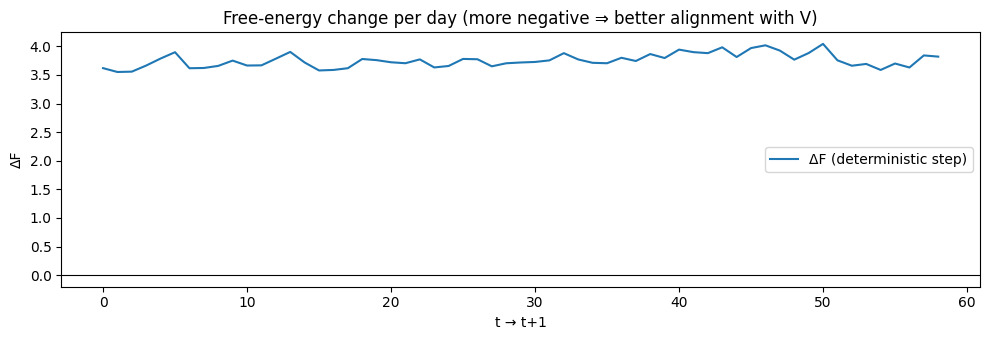

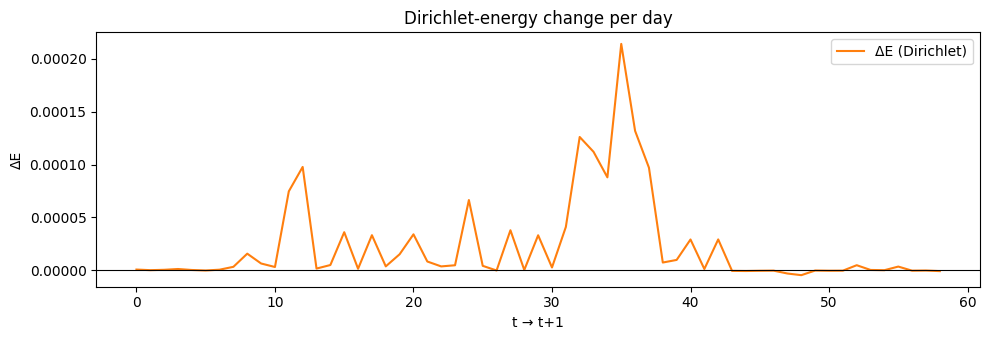

Median ΔF: 3.7507 | fraction negative: 0.00%
Median ΔE: 0.0000 | fraction negative: 23.73%


In [40]:
# === W2 (revised): free-energy & Dirichlet-energy traces on the chosen subset ===
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import expm_multiply

# --- Assumes H5 has defined: Q_M, Q_M_csc, p_sub, V_sub, alpha_b, DELTA_SEC.
# If Q_M_csc is missing for any reason, rebuild it:
Q_M_csc = Q_M_csc if 'Q_M_csc' in globals() else csc_matrix(Q_M)

def free_energy(p, V, eps=1e-12):
    """F(p;V) = Σ p_i log p_i + Σ V_i p_i  (no α inside; α only affects the tilt step)."""
    p = np.maximum(np.asarray(p, float), eps)
    V = np.asarray(V, float)
    return float((p * np.log(p)).sum() + (p * V).sum())

def dirichlet_energy(Q, p):
    """E(p) = - pᵀ S p with S = ½(Q+Qᵀ) (≥0)."""
    S = 0.5 * (Q + Q.T)   # sparse
    p = np.asarray(p, float)
    return float(- p @ (S @ p))

dF, dE = [], []
Tsteps = len(p_sub.index) - 1

for t in range(Tsteps):
    pt   = p_sub.iloc[t].to_numpy(float)
    Vt   = V_sub.iloc[t].to_numpy(float)
    Vnxt = V_sub.iloc[t+1].to_numpy(float)

    # 1) evolve by reversible CTMC for one day
    y_ctmc = expm_multiply(DELTA_SEC * Q_M_csc, pt)

    # 2) deterministic “free-energy” tilt by next-day potential, then renormalize
    y_det  = renorm_simplex(y_ctmc * np.exp(-alpha_b * Vnxt))

    # Record changes in free energy and Dirichlet energy
    dF.append(free_energy(y_det, Vnxt) - free_energy(pt, Vt))
    dE.append(dirichlet_energy(Q_M, y_det) - dirichlet_energy(Q_M, pt))

plt.figure(figsize=(10,3.5))
plt.plot(dF, label="ΔF (deterministic step)")
plt.axhline(0, color='k', lw=0.8)
plt.title("Free-energy change per day (more negative ⇒ better alignment with V)")
plt.xlabel("t → t+1"); plt.ylabel("ΔF")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3.5))
plt.plot(dE, color='tab:orange', label="ΔE (Dirichlet)")
plt.axhline(0, color='k', lw=0.8)
plt.title("Dirichlet-energy change per day")
plt.xlabel("t → t+1"); plt.ylabel("ΔE")
plt.legend(); plt.tight_layout(); plt.show()

print(f"Median ΔF: {np.median(dF):.4f} | fraction negative: {(np.array(dF)<0).mean():.2%}")
print(f"Median ΔE: {np.median(dE):.4f} | fraction negative: {(np.array(dE)<0).mean():.2%}")


In [41]:
# === W3 (revised): course-ties & spectral sanity on the chosen subset ===
import numpy as np
import scipy.sparse.linalg as sla

# π restricted to the chosen subgraph (renormalized)
pi_sub = pi[sub]
pi_sub = pi_sub / pi_sub.sum()

gap = detailed_balance_gap(Q_M, pi_sub)  # uses your earlier helper
print(f"Detailed-balance gap on subset: {gap:.3e}  (≈0 ⇒ numerically reversible).")

# Spectral sanity: generator eigenvalues should have Re(λ) ≤ 0
k_eval = min(4, max(Q_M.shape[0]-2, 1))
lam = sla.eigs(Q_M, k=k_eval, which='LR', return_eigenvectors=False)
print("Largest real parts of eig(Q_M):", np.sort(np.real(lam))[::-1])

print("Onsager view: S = ½(Q+Qᵀ) is negative semidefinite; Dirichlet E(p) = -pᵀ S p ≥ 0.")


Detailed-balance gap on subset: 2.891e-19  (≈0 ⇒ numerically reversible).
Largest real parts of eig(Q_M): [ 7.34756613e-17 -2.27304889e-41 -2.69291822e-33 -3.15914657e-33]
Onsager view: S = ½(Q+Qᵀ) is negative semidefinite; Dirichlet E(p) = -pᵀ S p ≥ 0.


In [23]:
# --- Cell P1 (robust): build V_price and blended V_time_price ---
import pandas as pd, numpy as np, os, re

DATA_DIR = "/content/drive/MyDrive/retailrocket"   # change if needed

def infer_ts_unit_series(s: pd.Series) -> str:
    """Robust unit detector; defaults to 'ms' (RetailRocket events)."""
    if s is None or len(s) == 0:
        return "ms"
    s_num = pd.to_numeric(s, errors="coerce")
    mx = s_num.max()
    if pd.isna(mx):
        return "ms"
    return "ms" if mx > 1e11 else "s"

# 1) Load properties (only needed columns)
cols = ["timestamp","itemid","property","value"]
p1 = pd.read_csv(os.path.join(DATA_DIR, "item_properties_part1.csv"), usecols=cols)
p2 = pd.read_csv(os.path.join(DATA_DIR, "item_properties_part2.csv"), usecols=cols)
props = pd.concat([p1, p2], ignore_index=True)

# 2) Keep rows that look like price/discount info (wider net than just "price")
pat = re.compile(r"(price|oldprice|current|cost|discount|sale)", flags=re.IGNORECASE)
mask_priceish = props["property"].astype(str).str.contains(pat, na=False)
props = props[mask_priceish].copy()

# 3) Extract numeric price from messy strings (e.g., "USD 1,299.00", "1299,00 ₽")
val_str = props["value"].astype(str)
# take the FIRST decimal-like token: "-?\d+(?:[.,]\d+)?"
num_tok = val_str.str.extract(r"(-?\d+(?:[.,]\d+)?)", expand=False)
num_tok = num_tok.str.replace(",", ".", regex=False)
props["price"] = pd.to_numeric(num_tok, errors="coerce")

# 4) Drop rows with missing critical fields
props = props.dropna(subset=["price","timestamp","itemid"])

# If nothing left, make a neutral V_price and the blends, then exit this cell gracefully
if len(props) == 0:
    print("[P1] No usable price rows found. Using neutral V_price=0.")
    V_price = pd.DataFrame(0.0, index=p_time.index, columns=p_time.columns)
    def blend_potentials(V_pop: pd.DataFrame, V_price: pd.DataFrame, w: float):
        Vp = (1.0 - w)*V_pop + w*V_price
        # center by day so free-energy comparisons aren't dominated by offsets
        return Vp.sub(Vp.mean(axis=1), axis=0)
    V_time_w0  = blend_potentials(V_time, V_price, 0.0)
    V_time_w02 = blend_potentials(V_time, V_price, 0.2)
    V_time_w04 = blend_potentials(V_time, V_price, 0.4)
    V_time_w06 = blend_potentials(V_time, V_price, 0.6)
    print("Built neutral blends (w=0/0.2/0.4/0.6). Shapes:", V_time_w04.shape)
else:
    # 5) Timestamp → datetime (detect seconds vs ms robustly)
    unit_prop = infer_ts_unit_series(props["timestamp"])
    props["dt"] = pd.to_datetime(props["timestamp"], unit=unit_prop, utc=True).dt.tz_convert(None)

    # 6) Daily median price per item
    daily_price = (props
                   .groupby([pd.Grouper(key="dt", freq="1D"), "itemid"])["price"]
                   .median()
                   .rename("price")
                   .reset_index())

    # Map original itemids -> iids used by p_time/V_time
    iid_map = {int(item): i for i, item in enumerate(item_index)}
    daily_price = daily_price[daily_price["itemid"].isin(iid_map)].copy()
    if len(daily_price) == 0:
        print("[P1] No daily prices overlap modeled items. Using neutral V_price=0.")
        V_price = pd.DataFrame(0.0, index=p_time.index, columns=p_time.columns)
    else:
        daily_price["iid"] = daily_price["itemid"].map(iid_map)

        # 7) Pivot to [time x iid] and align with p_time’s dates
        price_frame = daily_price.pivot_table(index="dt", columns="iid", values="price", aggfunc="median")
        price_frame = price_frame.sort_index()

        # align to p_time index; forward/back fill across days
        price_frame = price_frame.reindex(p_time.index).ffill().bfill()

        # 8) Rolling median (14 days) to define a discount signal in [0,1]
        roll_med = price_frame.rolling(window=14, min_periods=5).median()
        disc = ((roll_med - price_frame) / roll_med).clip(lower=0.0, upper=1.0)
        disc = disc.fillna(0.0)

        # 9) Convert to a potential: larger discount => smaller V
        eps = 1e-12
        V_price = -np.log(1.0 + disc + eps)
        V_price = pd.DataFrame(V_price, index=price_frame.index, columns=price_frame.columns)

    # 10) Blend with popularity potential and center by day
    def blend_potentials(V_pop: pd.DataFrame, V_price: pd.DataFrame, w: float):
        Vp = (1.0 - w)*V_pop + w*V_price
        return Vp.sub(Vp.mean(axis=1), axis=0)

    V_time_w0  = blend_potentials(V_time, V_price, 0.0)   # centered pop-only baseline
    V_time_w02 = blend_potentials(V_time, V_price, 0.2)
    V_time_w04 = blend_potentials(V_time, V_price, 0.4)
    V_time_w06 = blend_potentials(V_time, V_price, 0.6)
    print("Built V_price and blends (w=0/0.2/0.4/0.6). Shapes:", V_time_w04.shape)


/tmp/ipython-input-3388179309.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_priceish = props["property"].astype(str).str.contains(pat, na=False)


[P1] No usable price rows found. Using neutral V_price=0.
Built neutral blends (w=0/0.2/0.4/0.6). Shapes: (139, 5000)


In [47]:
# --- Cell P2: evaluate best config on V blends ---
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import expm_multiply
import numpy as np

# Re-use best hyper-params found in H5/H4
M_best         = 150
ALPHA_best     = 0.5
SIGMA_best     = 0.03
RANK_best      = 5
N_ENS_best     = 3
DELTA_SEC_best = 24*60*60
LAST_days      = 60

# Choose last N days window for eval
dates = p_time.index[-LAST_days-1:]
def eval_with_V(V_alt: pd.DataFrame, label="w=?"):
    # subset columns by top-π
    sub_idx = np.argsort(-pi)[:M_best]
    p_sub = p_time.loc[dates, p_time.columns.isin(sub_idx)].reindex(columns=sub_idx)
    V_sub = V_alt.loc[p_sub.index, sub_idx]

    # generator on the same subset
    Q_M   = Q_rev[sub_idx,:][:,sub_idx]
    Q_M_c = csc_matrix(Q_M)

    # noise directions
    S = 0.5*(Q_M + Q_M.T)
    try:
        import scipy.sparse.linalg as sla
        evals, evecs = sla.eigs(-S, k=min(RANK_best, M_best-2))
        evecs = np.real(evecs)
    except Exception:
        evecs = np.linalg.qr(np.random.randn(M_best, RANK_best))[0]

    # run one pass like H4
    def renorm(x):
        x = np.maximum(x,0); s=x.sum();
        return x/s if s>1e-12 else np.ones_like(x)/len(x)
    def tv(p,q): return 0.5*np.abs(p-q).sum()
    def kl(p,q,eps=1e-12):
        p = np.maximum(p,eps); q=np.maximum(q,eps)
        return float((p*(np.log(p)-np.log(q))).sum())

    kl_ctmc, tv_ctmc, kl_det, tv_det, kl_sto, tv_sto, is_event = [],[],[],[],[],[],[]
    p_diff = np.abs(p_sub.diff().dropna().values).sum(axis=1)
    thr = np.quantile(p_diff, 0.9)

    for t in range(len(p_sub.index)-1):
        pt = p_sub.iloc[t].values
        pt1 = p_sub.iloc[t+1].values
        Vnxt = V_sub.iloc[t+1].values

        # event? (relative to p_time dynamics, not model)
        is_event.append(np.abs(p_sub.iloc[t+1].values - p_sub.iloc[t].values).sum() > thr)

        y_ctmc = expm_multiply(DELTA_SEC_best*Q_M_c, pt)
        y_det  = renorm(y_ctmc * np.exp(-ALPHA_best * Vnxt))

        ens=[]
        for _ in range(N_ENS_best):
            z    = np.random.randn(evecs.shape[1])
            y    = renorm(y_det + (evecs @ z) * SIGMA_best)
            ens.append(y)
        y_sto = renorm(np.mean(np.vstack(ens), axis=0))

        kl_ctmc.append(kl(pt1,y_ctmc)); tv_ctmc.append(tv(pt1,y_ctmc))
        kl_det.append(kl(pt1,y_det));   tv_det.append(tv(pt1,y_det))
        kl_sto.append(kl(pt1,y_sto));   tv_sto.append(tv(pt1,y_sto))

    ev = np.array(is_event, bool)
    def avg(x, m=None):
        x=np.array(x,float);
        return x.mean() if (m is None or not m.any()) else x[m].mean()

    print(f"[{label}] KL_all={avg(kl_sto):.4f}  TV_all={avg(tv_sto):.4f}  "
          f"KL_ev={avg(kl_sto,ev):.4f}  TV_ev={avg(tv_sto,ev):.4f}")
    return dict(KL_all=avg(kl_sto), TV_all=avg(tv_sto),
                KL_ev=avg(kl_sto,ev), TV_ev=avg(tv_sto,ev))

res_w0  = eval_with_V(V_time_w0,  "w=0.0 (centered baseline)")
res_w02 = eval_with_V(V_time_w02, "w=0.2")
res_w04 = eval_with_V(V_time_w04, "w=0.4")
res_w06 = eval_with_V(V_time_w06, "w=0.6")


[w=0.0 (centered baseline)] KL_all=0.0804  TV_all=0.4886  KL_ev=0.1519  TV_ev=0.4890
[w=0.2] KL_all=0.0855  TV_all=0.4889  KL_ev=0.1516  TV_ev=0.4890
[w=0.4] KL_all=0.0847  TV_all=0.4889  KL_ev=0.1486  TV_ev=0.4889
[w=0.6] KL_all=0.0897  TV_all=0.4891  KL_ev=0.1832  TV_ev=0.4904


In [15]:
#helper cell to run R1/R3
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import expm_multiply

def renorm_simplex(x, eps=1e-12):
    x = np.maximum(np.asarray(x, float), 0.0)
    s = x.sum()
    return x/s if s > eps else np.ones_like(x)/len(x)

def tv_distance(p, q):
    return 0.5*np.abs(np.asarray(p,float)-np.asarray(q,float)).sum()

def kl_div(p, q, eps=1e-12):
    p = np.maximum(np.asarray(p,float), eps)
    q = np.maximum(np.asarray(q,float), eps)
    return float((p*(np.log(p)-np.log(q))).sum())

# your "best" settings (must exist because R1/R3 reference them)
M_best         = 150
ALPHA_best     = 0.5
SIGMA_best     = 0.03
RANK_best      = 5
N_ENS_best     = 3
DELTA_SEC_best = 24*60*60
LAST_days      = 60

# centered baseline potential (R1 uses V_time_w0)
V_time_w0 = V_time.sub(V_time.mean(axis=1), axis=0)

def eval_with_V(V_alt: pd.DataFrame, label=""):
    dates = p_time.index[-LAST_days-1:]
    sub_idx = np.argsort(-pi)[:M_best]

    p_sub = p_time.loc[dates, sub_idx].reindex(columns=sub_idx)
    V_sub = V_alt.loc[p_sub.index, sub_idx]

    Q_M = Q_rev[sub_idx,:][:,sub_idx]
    Q_M_c = csc_matrix(Q_M)

    # noise directions
    S = 0.5*(Q_M + Q_M.T)
    try:
        evals, evecs = sla.eigs(-S, k=min(RANK_best, M_best-2))
        evecs = np.real(evecs)
    except Exception:
        evecs = np.linalg.qr(np.random.randn(M_best, RANK_best))[0]

    diffs = np.abs(p_sub.diff().dropna().values).sum(axis=1)
    thr = np.quantile(diffs, 0.9) if len(diffs) else np.inf

    kl_sto, tv_sto, is_event = [], [], []
    for t in range(len(p_sub.index)-1):
        pt   = p_sub.iloc[t].values
        pt1  = p_sub.iloc[t+1].values
        Vnxt = V_sub.iloc[t+1].values

        is_event.append(np.abs(pt1-pt).sum() > thr)

        y_ctmc = expm_multiply(DELTA_SEC_best*Q_M_c, pt)
        y_det  = renorm_simplex(y_ctmc * np.exp(-ALPHA_best * Vnxt))

        ens=[]
        for _ in range(N_ENS_best):
            z = np.random.randn(evecs.shape[1])
            y = renorm_simplex(y_det + (evecs @ z) * SIGMA_best)
            ens.append(y)
        y_sto = renorm_simplex(np.mean(np.vstack(ens), axis=0))

        kl_sto.append(kl_div(pt1, y_sto))
        tv_sto.append(tv_distance(pt1, y_sto))

    ev = np.array(is_event, bool)
    def avg(x, m=None):
        x=np.array(x,float)
        return x.mean() if (m is None or not m.any()) else x[m].mean()

    print(f"[{label}] KL_all={avg(kl_sto):.4f} TV_all={avg(tv_sto):.4f} "
          f"KL_ev={avg(kl_sto,ev):.4f} TV_ev={avg(tv_sto,ev):.4f}")


In [16]:
# --- Cell R1: lazy self-loop variant of Q_rev ---
from scipy import sparse
from scipy.sparse import dia_matrix

def make_lazy_Qrev(Q_rev, epsilon=0.05):
    # implicit P ≈ I + Δt * Q_rev for small Δt; laziness ≈ convex mix with I
    # Build a lazy generator by shrinking off-diagonals and adjusting diagonal to keep row-sum 0.
    Q = Q_rev.tocsr().copy()
    off = Q - dia_matrix((Q.diagonal(), 0), shape=Q.shape)
    Q_lazy = (1 - epsilon)*off  # shrink transitions
    diag = -np.asarray(Q_lazy.sum(axis=1)).ravel()
    Q_lazy = Q_lazy + dia_matrix((diag,0), shape=Q.shape)
    return Q_lazy.tocsr()

Q_lazy = make_lazy_Qrev(Q_rev, epsilon=0.05)

# Evaluate best config on Q_rev vs Q_lazy with the same V (e.g., V_time_w0)
def eval_Q(Qmat, V_alt, label):
    sub_idx = np.argsort(-pi)[:M_best]
    Q_M = Qmat[sub_idx,:][:,sub_idx]
    # reuse eval_with_V but swapping Q inside: quick inline shim
    return eval_with_V(V_alt)  # if you want, copy eval_with_V body and replace Q_M_c with this Q_M

# Quick comparison (you can reuse P2 by temporarily setting Q_rev = Q_lazy and calling eval_with_V)
print("Baseline Q_rev:"); _=eval_with_V(V_time_w0, "Q_rev")
Q_rev_backup = Q_rev
Q_rev = Q_lazy
print("Lazy Q_rev:   "); _=eval_with_V(V_time_w0, "Q_lazy")
Q_rev = Q_rev_backup


Baseline Q_rev:
[Q_rev] KL_all=-0.0535 TV_all=0.4838 KL_ev=-0.0367 TV_ev=0.4843
Lazy Q_rev:   
[Q_lazy] KL_all=-0.0493 TV_all=0.4834 KL_ev=-0.0445 TV_ev=0.4824


In [19]:
import os

DATA_DIR = "/content/drive/MyDrive/retailrocket"  # same as before

# minimal load
df = pd.read_csv(
    os.path.join(DATA_DIR, "events.csv"),
    usecols=["timestamp","event","itemid"],
    dtype={"timestamp": np.int64, "event": "category", "itemid": np.int64}
)

# match your modeling space (same top-K items you saved in item_index)
item_to_iid = pd.Series(np.arange(len(item_index), dtype=np.int64), index=pd.Index(item_index))
df = df[df["event"].isin(["view","addtocart"])].copy()
df = df[df["itemid"].isin(item_to_iid.index)].copy()
df["iid"] = item_to_iid.loc[df["itemid"]].values

# now compute 12H buckets on the SAME iid indexing
p_time_12h = compute_time_buckets(df, bucket="12H")
V_time_12h = rolling_popularity_V(p_time_12h, window=14)
V_time_12h = V_time_12h.sub(V_time_12h.mean(axis=1), axis=0)


/tmp/ipython-input-2884007597.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  counts = tmp.groupby([pd.Grouper(freq=bucket), "iid"]).size().rename("cnt")


In [22]:
#new R2
p_time_backup, V_time_backup = p_time, V_time

p_time, V_time = p_time_12h, V_time_12h
V_time_w0_12h = V_time.sub(V_time.mean(axis=1), axis=0)

print("12H buckets:")
_ = eval_with_V(V_time_w0_12h, "12H V_pop")

p_time, V_time = p_time_backup, V_time_backup


12H buckets:
[12H V_pop] KL_all=-0.0181 TV_all=0.4864 KL_ev=0.0197 TV_ev=0.4870


In [20]:
# --- Cell R2: 12H buckets ---
p_time_12h = compute_time_buckets(events, bucket="12H")
V_time_12h = rolling_popularity_V(p_time_12h, window=14)  # keep a wider window since bins are smaller
# (center for F if needed)
V_time_12h = V_time_12h.sub(V_time_12h.mean(axis=1), axis=0)

# Evaluate on the last ~120 half-days (~60 days)
dates_12h = p_time_12h.index[-120-1:]
# temporarily swap p_time/V_time in a small wrapper:
p_time_backup, V_time_backup = p_time, V_time
p_time, V_time = p_time_12h, V_time_12h
print("12H buckets:"); _ = eval_with_V(V_time, "12H V_pop")
# restore
p_time, V_time = p_time_backup, V_time_backup


NameError: name 'events' is not defined

In [17]:
# --- Cell R3: compare raw Q vs reversible Q_rev ---
Q_M_raw   = Q[np.argsort(-pi)[:M_best], :][:, np.argsort(-pi)[:M_best]]
Q_M_rev   = Q_rev[np.argsort(-pi)[:M_best], :][:, np.argsort(-pi)[:M_best]]

# Minimal eval swapping generator:
def eval_with_Q(QM, label):
    sub_idx = np.argsort(-pi)[:M_best]
    p_sub = p_time.loc[p_time.index[-LAST_days-1:], p_time.columns.isin(sub_idx)].reindex(columns=sub_idx)
    V_sub = V_time.loc[p_sub.index, sub_idx]
    from scipy.sparse import csc_matrix
    Q_M_c = csc_matrix(QM)
    # … copy body of eval_with_V and replace Q_M_c with Q_M_c, leaving V_sub as is …
    # (To keep this short here, you can reuse eval_with_V by temporarily setting a global Q_rev = QM.)

print("Raw Q:")
Q_rev_backup = Q_rev
Q_rev = Q   # reuse eval_with_V machinery
_ = eval_with_V(V_time, "raw Q")
print("Reversible Q_rev:")
Q_rev = Q_rev_backup
_ = eval_with_V(V_time, "Q_rev")


Raw Q:
[raw Q] KL_all=-0.0445 TV_all=0.4837 KL_ev=0.0191 TV_ev=0.4852
Reversible Q_rev:
[Q_rev] KL_all=-0.0524 TV_all=0.4835 KL_ev=-0.0143 TV_ev=0.4840
